# Golden Model For DFE 
### Hazem Yasser Mahmoud 


## imports

In [108]:
import numpy as np
from scipy.signal import firwin , freqz , resample_poly
import matplotlib.pyplot as plt

## DFE stages
<img src="images/DFE.png" alt="DFE diagram" width = "600" height="300" >

### Paper Proposed rational Polyphase resampler structure
note that each branch has more coeff than in the image each sybsequent two have 6 in differnce so h0,h6,h12....

https://www.researchgate.net/profile/Abhishek-Kumar-202/publication/319763113
<img src="images/paper polyphase.PNG" alt="paper proposed structure" width="600" height ="300" >


In [109]:
def polyphase_resample(x, L, M,h):
    """
    Rational resampler using explicit 3D polyphase structure with
    parallel main phases and interleaved subphases.
    """

    # 2. Polyphase decomposition into M x L branches
    phases = []
    for m in range(M):   # main phases
        row = []
        for l in range(L):  # sub-phases
            row.append(h[m + l*M :: L*M])
        phases.append(row)

    # 3. Split input into M decimated streams (one per main phase)
    x_p = [x[m::M] for m in range(M)]

    # 4. Process each main phase separately
    parallel_outputs = [[] for _ in range(M)]

    for m in range(M):       # main phase
        x_m = x_p[m]
        h_m = phases[m]

        parallel_outputs[m].extend([0.0] * m)
        
        for n in range(len(x_m)):
            subphase_samples = []
            for l in range(L):   # subphases
                acc = 0.0
                h_ml = h_m[l]
                for k in range(len(h_ml)):
                    if n - k >= 0:
                        acc += h_ml[k] * x_m[n - k]
                subphase_samples.append(acc)
            # interleave subphase results into one stream per main phase
            parallel_outputs[m].extend(subphase_samples)

    # 5. Sum the parallel streams (sample-wise)
    min_len = min(len(p) for p in parallel_outputs)
    summed_output = np.zeros(min_len)
    for m in range(M):
        summed_output += np.array(parallel_outputs[m][:min_len])

    return np.asarray(summed_output) #, parallel_outputs


### traditional polyphase resampler structure structure
<img src="images/traidiotional polyphase copy.png" alt="paper proposed structure" width = "600" height="300" >

In [110]:
def polyphase_traditional(x, L, M, h):

    phases = [h[l::L] for l in range(L)]
    y = []
    t = 0
    for n in range(len(x)):
        for l in range(L):
            acc = 0.0
            for k in range(len(phases[l])):
                if n - k >= 0:
                    acc += phases[l][k] * x[n - k]
            # output sample if timing hits a downsample point
            if t % M == 0:
                y.append(acc)
            t += 1
    return np.array(y)

### biquad_IIR_DFII_T
<img src="images/biquaad_DF2_T.PNG" alt="biquad IIR DFII T" width = "600" height="300" >

In [111]:
def biquad_df2t(x, b, a):
    """
    Floating-point Direct Form II Transposed biquad filter
    x : input signal (float array)
    b : [b0, b1, b2]
    a : [1, a1, a2]  (a[0] must be 1)
    returns y : filtered output (float array)
    """
    N = len(x)
    y = np.zeros(N)
    s1, s2 = 0.0, 0.0  # delay elements

    b0, b1, b2 = b
    _, a1, a2 = a

    for n in range(N):
        # Direct Form II Transposed structure
        y_n = b0 * x[n] + s1
        s1 = b1 * x[n] - a1 * y_n + s2
        s2 = b2 * x[n] - a2 * y_n
        y[n] = y_n

    return y

### CIC + comp FIR
<img src="images/cic.PNG" alt="biquad IIR DFII T" width = "600" height="300" >

#### CIC no compensation 

#### using fixed point integers 
more prone to overflow at high freq but accurate HW modelling. overflow happen for big frequency near nyqist

In [112]:
def cic_decimator(x, R=2, M=1, N=5, B_in=16, B_out=16):
    """
    CIC decimator model with FPGA-style bit growth and truncation.
    
    Parameters:
        x : np.ndarray      - Input signal in range [-1, 1)
        R : int             - Decimation factor
        M : int             - Differential delay
        N : int             - Number of stages
        B_in : int          - Input bit width
        B_out : int         - Final output width
        
    Returns:
        y_out : np.ndarray  - Output after decimation and truncation
    """
    x = np.asarray(x, dtype=np.float64)

    # Convert to fixed-point integer
    x_int = np.round(x * (2**(B_in - 1))).astype(np.int64)

    n_in = len(x_int)
    integ = np.zeros((N, n_in), dtype=np.int64)

    # --- Integrator section ---
    integ[0, 0] = x_int[0]
    for i in range(1, n_in):
        integ[0, i] = integ[0, i-1] + x_int[i]
    for stage in range(1, N):
        integ[stage, 0] = integ[stage-1, 0]
        for i in range(1, n_in):
            integ[stage, i] = integ[stage, i-1] + integ[stage-1, i]
    y_int = integ[-1, :]

    # --- Decimate ---
    y_dec = y_int[::R]

    # --- Comb section ---
    n_out = len(y_dec)
    comb = np.zeros((N, n_out), dtype=np.int64)
    for stage in range(N):
        delay = np.zeros(M, dtype=np.int64)
        for i in range(n_out):
            cur_in = y_dec[i] if stage == 0 else comb[stage-1, i]
            cur_out = cur_in - delay[0]
            comb[stage, i] = cur_out
            delay = np.roll(delay, -1)
            delay[-1] = cur_in

    y_out = comb[-1, :]

    # --- Bit growth and truncation ---
    shift_bits = int(N * np.ceil(np.log2(R * M)))
    y_trunc = np.right_shift(y_out, shift_bits)
    y_float = y_trunc / (2**(B_out - 1))

    # Clip to [-1, 1)
    y_float = np.clip(y_float, -1, 1 - 1/(2**(B_out-1)))
    return y_float 


#### using quantized float 
no overflow at all 

In [113]:
def cic_decimator_2(x, R=2, M=1, N=5, B_in=16, B_out=16):
    """
    CIC decimator model (safe version, no overflow).
    Keeps same parameters and scaling behavior, 
    but uses float64 arithmetic internally.

    Parameters:
        x : np.ndarray      - Input signal in range [-1, 1)
        R : int             - Decimation factor
        M : int             - Differential delay
        N : int             - Number of stages
        B_in : int          - Input bit width
        B_out : int         - Final output width

    Returns:
        y_out : np.ndarray  - Output after decimation and truncation
    """
    x = np.asarray(x, dtype=np.float64)

    # --- Simulate quantization (just for realism) ---
    x_int = np.round(x * (2**(B_in - 1))) / (2**(B_in - 1))

    n_in = len(x_int)
    integ = np.zeros((N, n_in), dtype=np.float64)

    # --- Integrator section ---
    integ[0, 0] = x_int[0]
    for i in range(1, n_in):
        integ[0, i] = integ[0, i-1] + x_int[i]
    for stage in range(1, N):
        integ[stage, 0] = integ[stage-1, 0]
        for i in range(1, n_in):
            integ[stage, i] = integ[stage, i-1] + integ[stage-1, i]

    y_int = integ[-1, :]

    # --- Decimation ---
    y_dec = y_int[::R]

    # --- Comb section ---
    n_out = len(y_dec)
    comb = np.zeros((N, n_out), dtype=np.float64)
    for stage in range(N):
        delay = np.zeros(M, dtype=np.float64)
        for i in range(n_out):
            cur_in = y_dec[i] if stage == 0 else comb[stage-1, i]
            cur_out = cur_in - delay[0]
            comb[stage, i] = cur_out
            delay = np.roll(delay, -1)
            delay[-1] = cur_in

    y_out = comb[-1, :]

    # --- Bit growth and truncation emulation ---
    shift_bits = int(N * np.ceil(np.log2(R * M)))
    y_scaled = y_out / (2**shift_bits)

    # Clip to output range
    y_float = np.clip(y_scaled, -1, 1 - 1/(2**(B_out - 1)))
    return y_float

#### CIC compensated

In [114]:

def cic_comp(x, R=2):
    """
    CIC + Compensation FIR cascade.
    - If R == 1: bypass (return x unchanged)
    - Else: call cic_decimator_fpga() and convolve with compensation filter
    """
    if R == 1:
        return np.asarray(x, dtype=np.float64)

    # --- 1. Run CIC decimator ---
    # y_cic = cic_decimator(x, R=R)
    y_cic = cic_decimator_2(x, R=R)

    # --- 2. Load compensation filter coefficients ---
    coeff_path = f"comp_R{R}.txt"
    try:
        h_comp = np.loadtxt(coeff_path)/(2**15)
    except FileNotFoundError:
        raise FileNotFoundError(f"Compensation file '{coeff_path}' not found.")

    # --- 3. Manual convolution (low-level style) ---
    n = len(y_cic)
    L = len(h_comp)
    y_out = np.zeros(n + L - 1, dtype=np.float64)

    for i in range(n):
        for k in range(L):
            y_out[i + k] += y_cic[i] * h_comp[k]

    return y_out

## DFE (integrated stages)

In [115]:
def dfe_integrated(x, R=2):
    """
    Full DFE processing chain:
        1. Polyphase Resampler (L=2, M=3)
        2. Biquad Notch Filter
        3. CIC Decimator + Compensation FIR

    Loads coefficients from:
        - coeffs_fixed_q15.txt  (polyphase filter)
        - notch_b_q14.txt, notch_a_q14.txt  (biquad filter)
        - comp_R{R}.txt  (CIC compensation FIR)
    """
    
    # --- Stage 1: Polyphase Resampler ---
    L , M = 2,3
    h_15 = np.loadtxt("coeffs_fixed_q15.txt",dtype=int)/(2**15) *L
    P = int(np.ceil(len(h_15)/M/L))
    h = np.concatenate([h_15, np.zeros(M * P * L - len(h_15))])
    y = polyphase_resample(x, L=2, M=3, h=h)

    # --- Stage 2: Biquad Notch Filter ---
    b = np.loadtxt("notch_b_q14.txt")
    a = np.loadtxt("notch_a_q14.txt")
    frac_bits = 14
    b = b / (2**frac_bits)
    a = a / (2**frac_bits)
    y = biquad_df2t(y, b, a)

    # --- Stage 3: CIC + Compensation ---

    y_out = cic_comp(y, R=R)
    return y_out
    

## Helping Routines

### Quantize

In [116]:
def fixed_point_quantize(x, n_int=1, n_frac=15):
    """
    Quantize a value (or numpy array) x to signed fixed-point s.I.F format.

    Parameters:
        x: float or np.ndarray — input value(s)
        n_int: int — number of integer bits (excluding sign bit)
        n_frac: int — number of fractional bits

    Returns:
        qx: quantized value in float (after rounding)
        q_int: quantized integer representation (int)
    """
    import numpy as np

    # Compute limits
    scale = 2 ** n_frac
    max_val = (2 ** n_int) - (1 / scale)
    min_val = - (2 ** n_int)

    # Clamp input
    x_clamped = np.clip(x, min_val, max_val)

    # Quantize
    q_int = np.round(x_clamped * scale).astype(int)

    # Handle wrap-around if overflowed
    q_int = np.clip(q_int, -int(2 ** (n_int + n_frac)), int(2 ** (n_int + n_frac)) - 1)

    # Convert back to float
    qx = q_int / scale

    # return qx, q_int
    return qx
    

### Filter inspection

In [117]:
def inspect_filter(h, fs):
    # DC gain: Sum of filter coefficients (valid for FIR filters)
    dc_gain = np.sum(h)
    print(f"Filter length: {len(h)}, DC gain (sum of taps) = {dc_gain:.6f}")

    # Impulse response
    n = np.arange(len(h))  # Time indices for impulse response

    # Frequency response
    w, H = freqz(h, worN=4096)
    f = w * fs / (2 * np.pi)  # Convert rad/sample to Hz

    # Create side-by-side plots
    plt.figure(figsize=(12, 4))

    # Subplot 1: Impulse response
    plt.subplot(1, 2, 1)
    plt.stem(n, h, basefmt=" ")
    plt.xlabel('Sample index (n)')
    plt.ylabel('Amplitude')
    plt.title('Impulse Response')
    plt.grid(True)

    # Subplot 2: Frequency response
    plt.subplot(1, 2, 2)
    plt.plot(f / 1e6, 20 * np.log10(np.abs(H) + 1e-12))
    plt.axvline(3.0, color='r', linestyle='--', label='3 MHz (output Nyquist)')
    plt.xlabel('Frequency (MHz)')
    plt.ylabel('Magnitude (dB)')
    plt.title('Frequency Response')
    plt.grid(True)
    plt.legend()
    plt.xlim(0, fs / 2 / 1e6)

    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()

### plotting I/O

In [118]:
def plot_time_freq(x, y, fs_in, fs_out, title,samples=200,L=1,M=1,step = 200):
    fig, axes = plt.subplots(2,1, figsize=(12,6))
    
    # Trim to same duration for time plot
    min_samples = min(len(x), int(len(y)*fs_in/fs_out))
    x = x[:min_samples]
    y = y[:int(min_samples*fs_out/fs_in)]
    
    n_in = np.arange(len(x))/fs_in*1e6
    n_out = np.arange(len(y))/fs_out*1e6

    # ---- Time-domain ----
    axes[0].plot(n_in[samples-step:samples], x[samples-step:samples], label="Input")
    axes[0].plot(n_out[int((samples-step)*(L/M)):int(samples*(L/M))], y[int((samples-step)*(L/M)):int(samples*(L/M))], label="Output")
    axes[0].set_title(f"{title} - Time domain ( {step} samples)")
    axes[0].set_xlabel("Time (µs)")
    axes[0].legend()

    # ---- Frequency spectrum ----
    Nfft = 16384*64  # power of 2 for clean FFT
    X = np.fft.fftshift(np.fft.fft(x, Nfft))
    Y = np.fft.fftshift(np.fft.fft(y, Nfft))
    f_in = np.fft.fftshift(np.fft.fftfreq(Nfft, 1/fs_in))/1e6
    f_out = np.fft.fftshift(np.fft.fftfreq(Nfft, 1/fs_out))/1e6

    axes[1].plot(f_in, 20*np.log10(np.abs(X)+1e-12),label="input",color="blue")
    axes[1].plot(f_out, 20*np.log10(np.abs(Y)+1e-12),label="output", color="orange")
    axes[1].set_xlim([-max(fs_out/(2*1e6),fs_in/(2*1e6)), max(fs_out/(2*1e6),fs_in/(2*1e6))])
    axes[1].set_title("Output Spectrum")
    axes[1].set_xlabel("Frequency (MHz)")
    axes[1].set_ylabel("Magnitude (dB)")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

# Testing & Graphs

## Polyphase Filter

### Promplems and Solutions
1. For prpoer resampling the fir filter need to be $w_c = \frac{1}{\max(L, M)} \cdot \frac{F_s}{2}$

2. so we Design a Prototype FIR at 1.5 wher 1.4 lesss than .25dB and after 1.6 less than -80dB 

3. implementing this prototype FIR in polyphase structure give effective filtering at 3 MHz


### Paramaters definition & Filter Testing

Filter length: 228, DC gain (sum of taps) = 1.998474


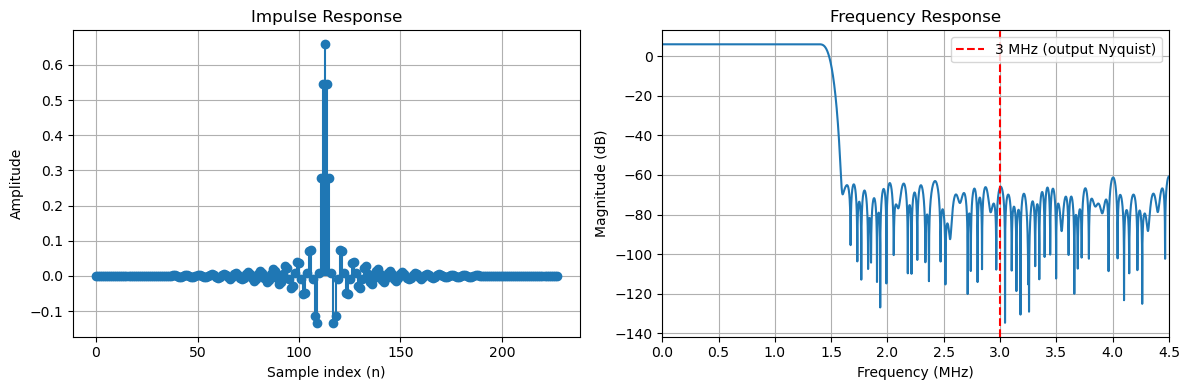

Input length: 9000
Final output length: 6000


In [119]:
# Example usage
fs_in = 9e6
L, M = 2, 3
fs_out = fs_in * L/M
N = 8192   # number of samples
t = np.arange(N) / fs_in 

#  # 1. Design prototype filter at upsampled rate

h_win = firwin(403, 1/ max(L,M) ) * L
h_15 = np.loadtxt("coeffs_fixed_q15.txt",dtype=int)/(2**15) *L
P = int(np.ceil(len(h_15)/M/L))
h = np.concatenate([h_15, np.zeros(M * P * L - len(h_15))])

inspect_filter(h,9e6)


# Example input: 1 MHz tone
t = np.arange(0, 9000) / fs_in
x = np.sin(2 * np.pi * 1e6 * t)

y = polyphase_resample(x, L, M,h)
print("Input length:", len(x))

print("Final output length:", len(y))

### prototype filter when not in polyphase strucure only filter at 1.5 MHz 

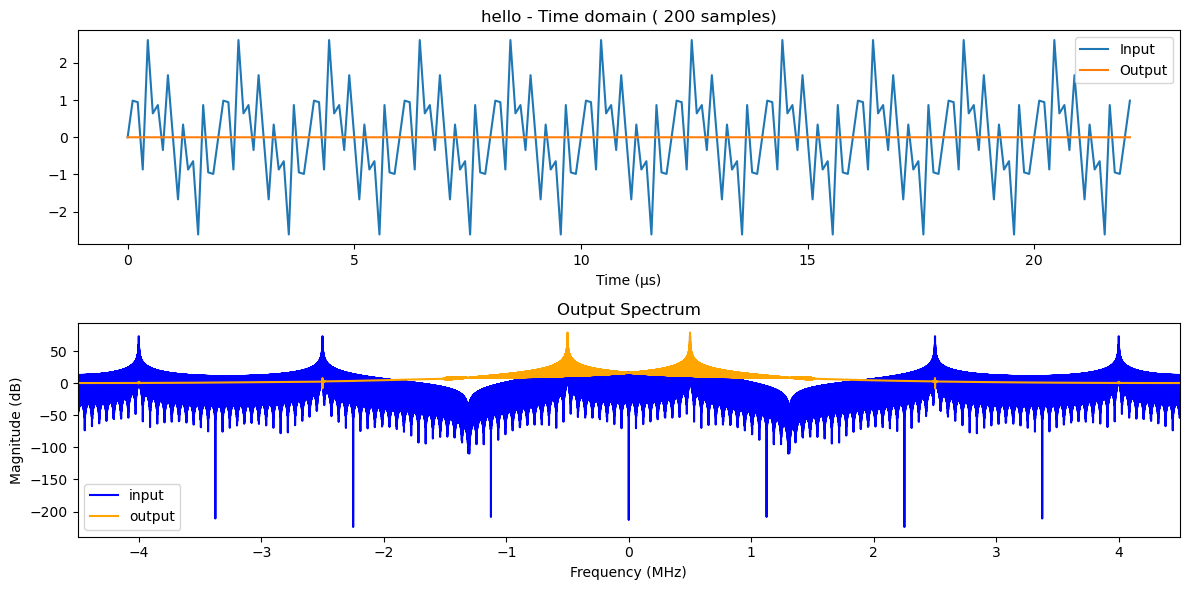

In [120]:
y = [] 
x = np.sin(2*np.pi*0.5e6*t) + np.sin(2*np.pi*2.5e6*t) + np.sin(2*np.pi*5e6*t)  
h_ml = firwin(603, 1/ max(2,3) ) * 2
for n in range(len(x)):
        acc = 0.0
        for k in range(len(h_ml)):
            if n - k >= 0:
                acc += h_ml[k] * x[n - k]
        y.append(acc)
plot_time_freq(x, y, fs_in, fs_in,"hello")

### I/O Testing 

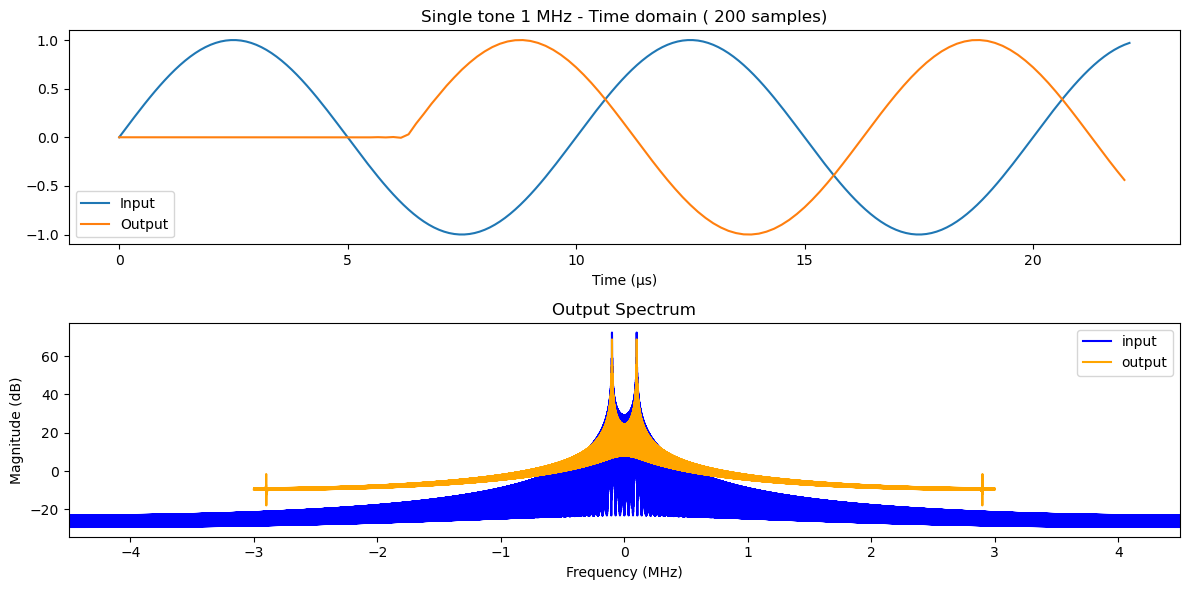

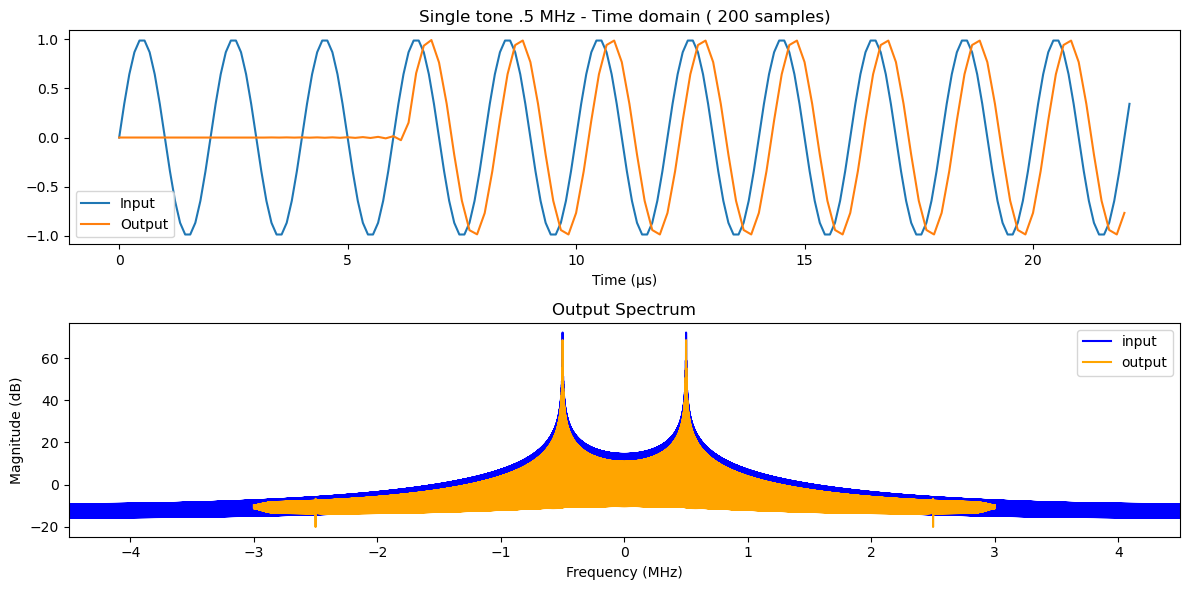

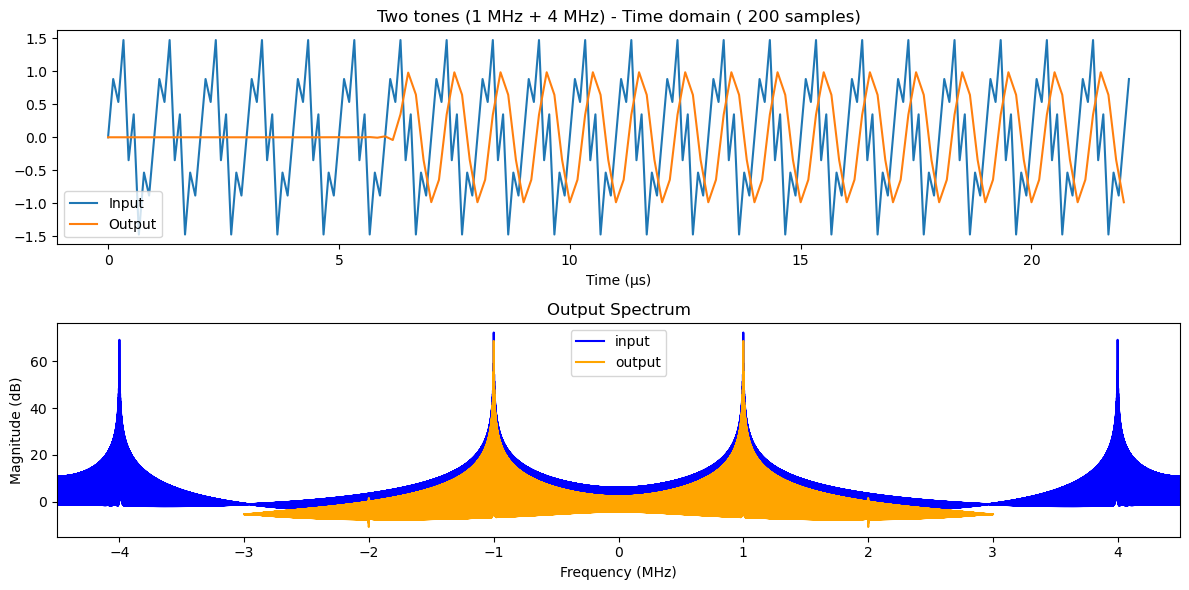

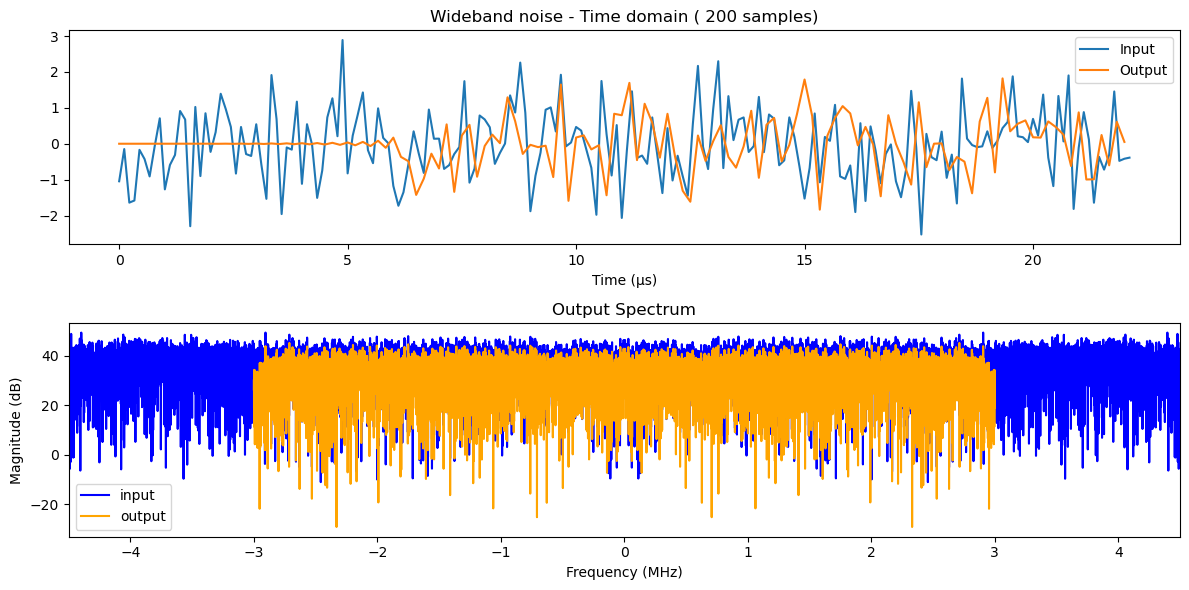

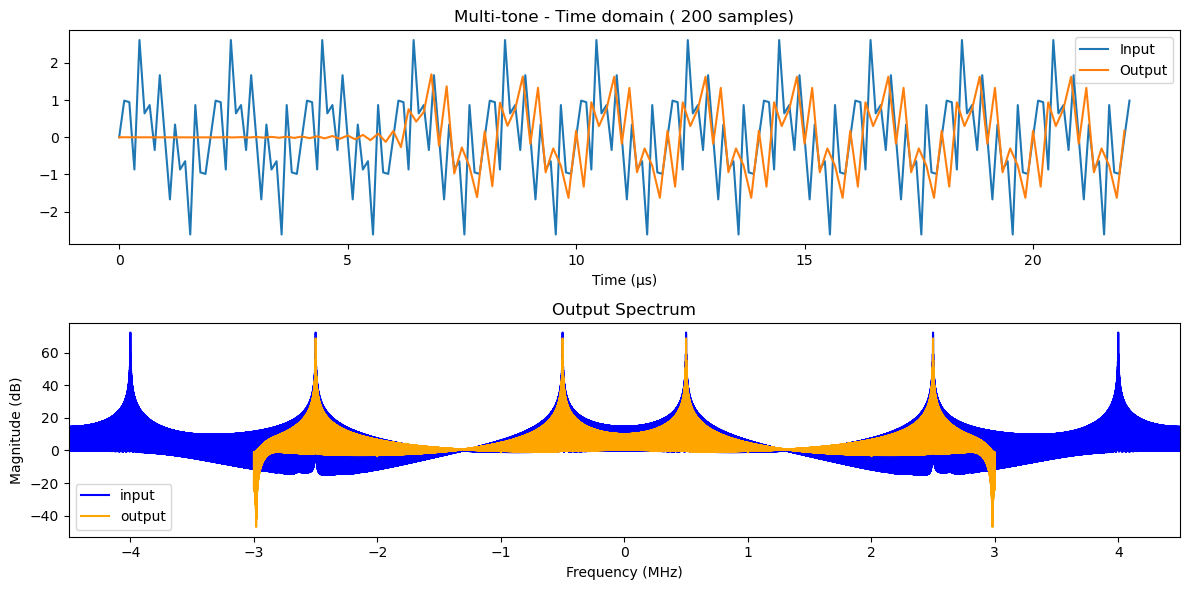

In [121]:
# ----------------- TESTING -----------------
fs_in = 9e6
L, M = 2, 3
fs_out = fs_in * L/M
N = 8192   # number of samples
t = np.arange(N) / fs_in 

# Different input signals
signals = {
    "Single tone 1 MHz": np.sin(2*np.pi*1e5*t),
    "Single tone .5 MHz": np.sin(2*np.pi*5e5*t),
    "Two tones (1 MHz + 4 MHz)": np.sin(2*np.pi*1e6*t) + 0.7*np.sin(2*np.pi*4e6*t),
    "Wideband noise": np.random.randn(N),
    "Multi-tone": np.sin(2*np.pi*0.5e6*t) + np.sin(2*np.pi*2.5e6*t) + np.sin(2*np.pi*5e6*t)
}

# Run tests
for name, sig in signals.items():
    y = polyphase_resample(sig, L, M,h)
    # y_2 = polyphase_traditional(sig, L, M,h)
    plot_time_freq(sig, y, fs_in, fs_out, name,200,L,M)
    # plot_time_freq(sig, y_2, fs_in, fs_out, name+" matlab",200,L,M)
    

### reference comparison

Single tone 1 MHz: MSE vs. SciPy = 1.69e+00


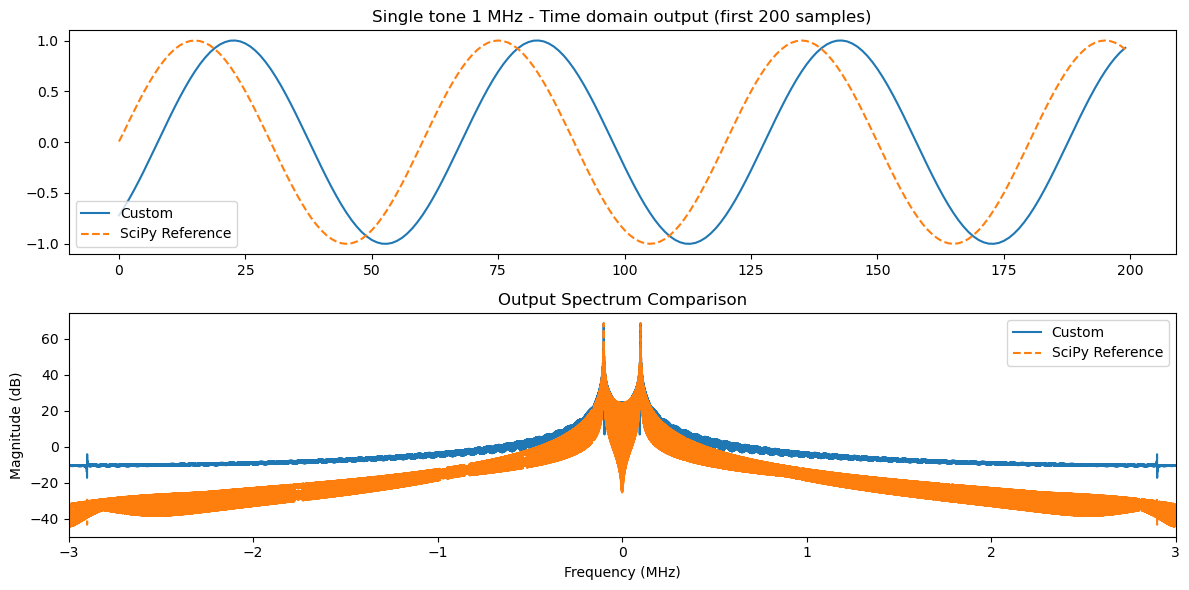

Single tone .5 MHz: MSE vs. SciPy = 3.58e-01


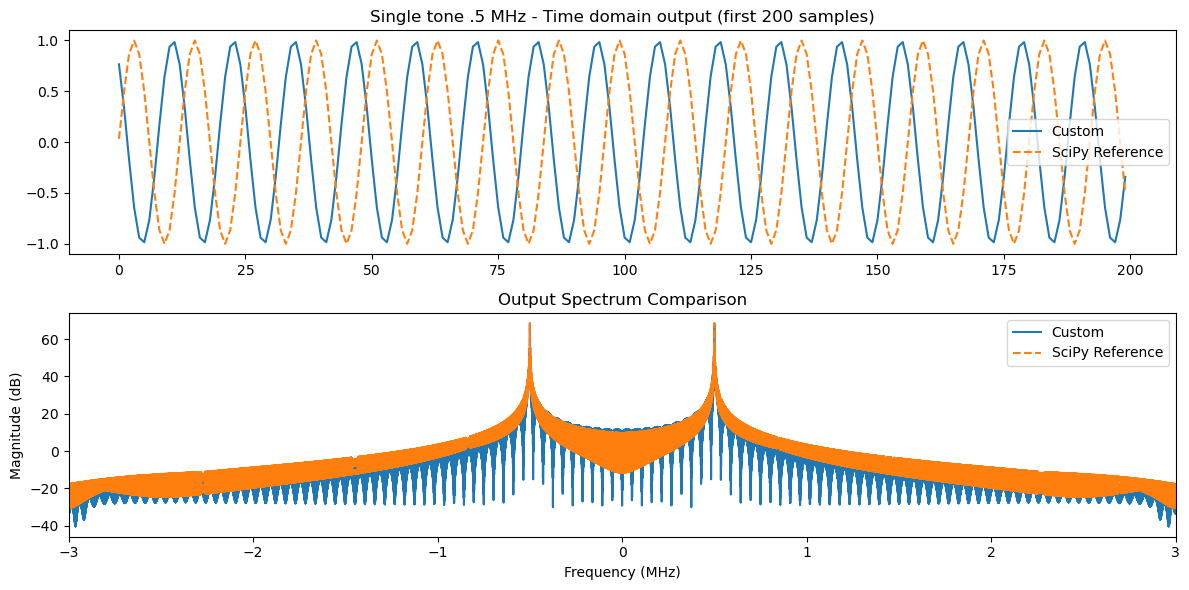

Two tones (1 MHz + 4 MHz): MSE vs. SciPy = 1.17e+00


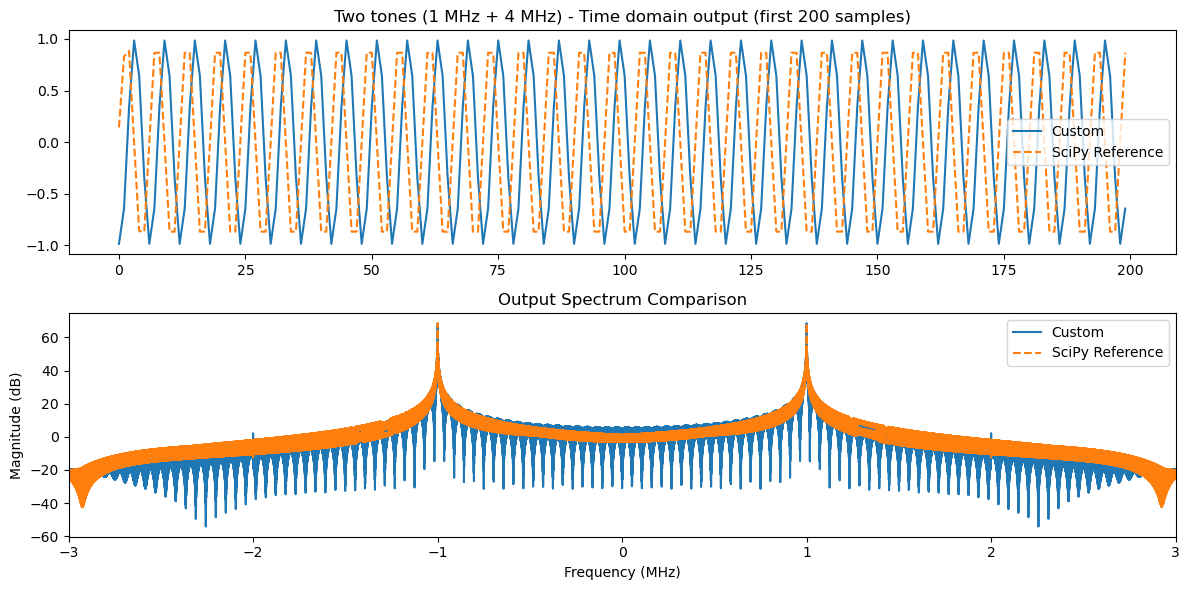

Wideband noise: MSE vs. SciPy = 1.25e+00


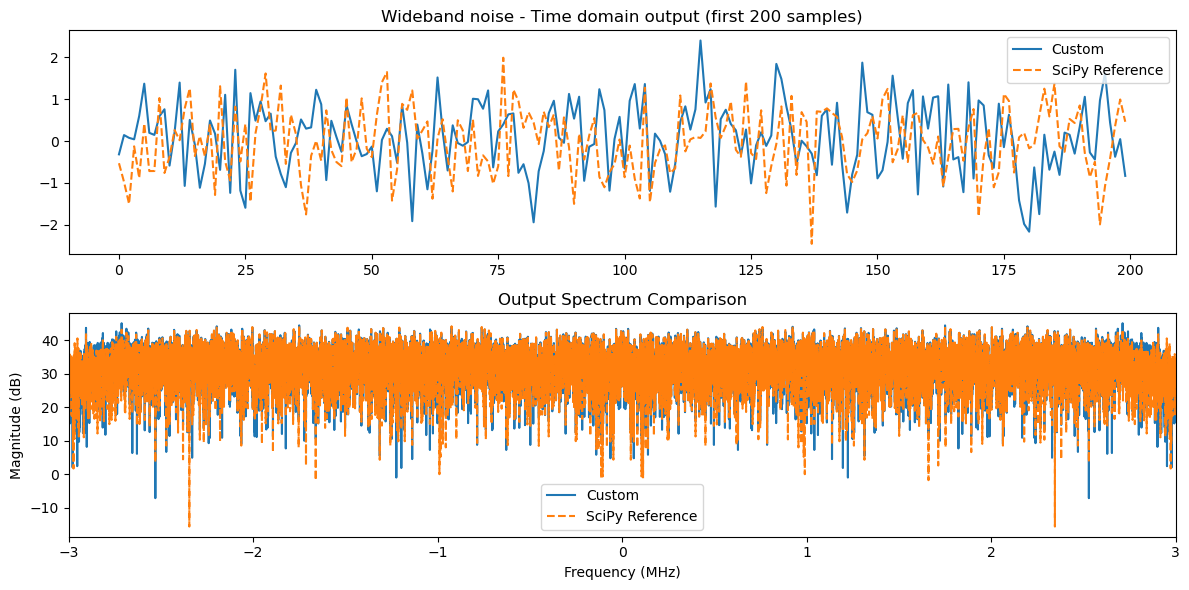

Multi-tone: MSE vs. SciPy = 1.65e+00


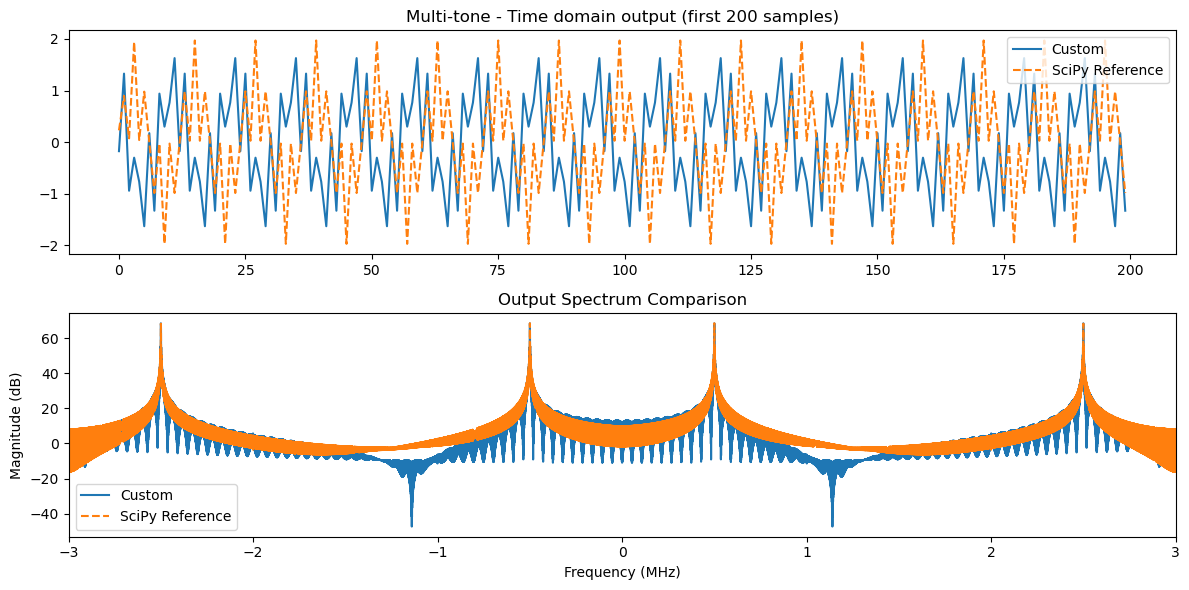

In [122]:
# ----------------- COMPARISON BLOCK -----------------
for name, sig in signals.items():
    # Your implementation
    y_custom = polyphase_resample(sig, L, M,h)

    # Reference implementation (SciPy)
    y_ref = resample_poly(sig, L, M, window=('kaiser', 8.6))  # default Kaiser ~0.01 dB ripple

    # --- Match lengths for fair comparison ---
    min_len = min(len(y_custom), len(y_ref))
    y_custom = y_custom[:min_len]
    y_ref = y_ref[:min_len]

    # --- Time-domain difference ---
    mse = np.mean((y_custom - y_ref)**2)
    print(f"{name}: MSE vs. SciPy = {mse:.2e}")

    # --- Plot comparison ---
    plt.figure(figsize=(12,6))

    # First 200 samples (time domain)
    plt.subplot(2,1,1)
    plt.plot(y_custom[150:350], label="Custom")
    plt.plot(y_ref[:200], '--', label="SciPy Reference")
    plt.title(f"{name} - Time domain output (first 200 samples)")
    plt.legend()

    # Spectrum comparison
    Nfft = 16384
    Yc = np.fft.fftshift(np.fft.fft(y_custom, Nfft))
    Yr = np.fft.fftshift(np.fft.fft(y_ref, Nfft))
    f = np.fft.fftshift(np.fft.fftfreq(Nfft, 1/fs_out))/1e6

    plt.subplot(2,1,2)
    plt.plot(f, 20*np.log10(np.abs(Yc)+1e-12), label="Custom")
    plt.plot(f, 20*np.log10(np.abs(Yr)+1e-12), '--', label="SciPy Reference")
    plt.xlim([-fs_out/(2*1e6), fs_out/(2*1e6)])
    plt.title("Output Spectrum Comparison")
    plt.xlabel("Frequency (MHz)")
    plt.ylabel("Magnitude (dB)")
    plt.legend()

    plt.tight_layout()
    plt.show()

## IIR Notch

### I/O + Filter Testing 

Loaded Q1.14 coefficients:
b_q14 = [15725 25443 15725]
a_q14 = [16384 25443 15066]
b_fixed = [0.95977783 1.55291748 0.95977783]
a_fixed = [1.         1.55291748 0.91955566]


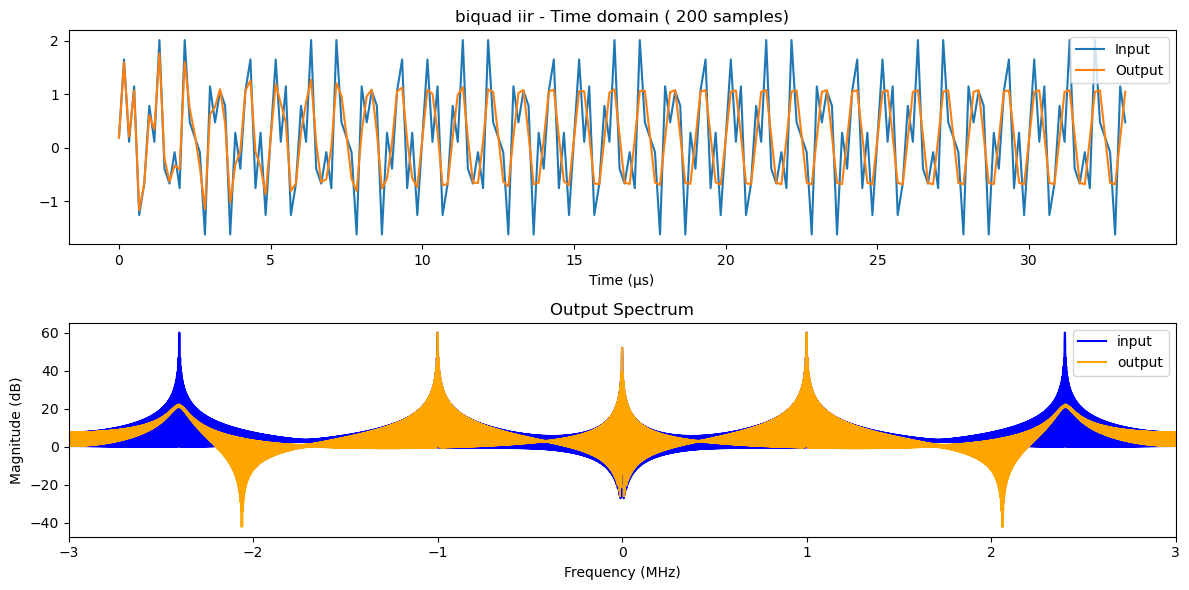

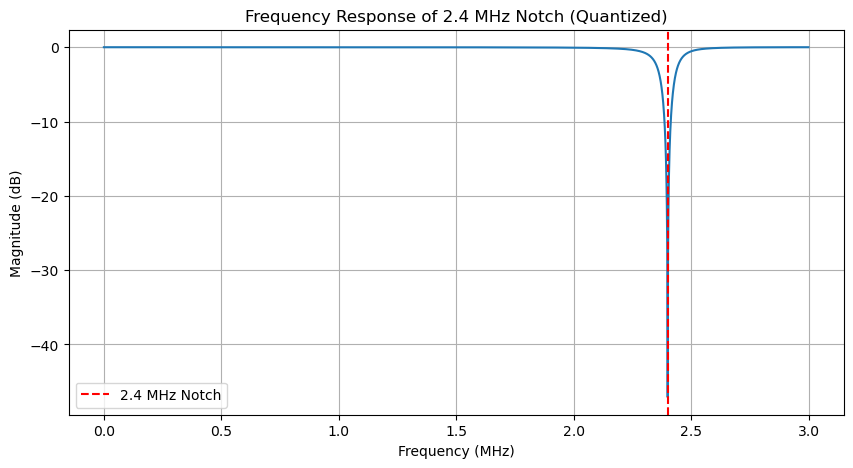

In [123]:

b_q14 = np.loadtxt("notch_b_q14.txt", dtype=int)
a_q14 = np.loadtxt("notch_a_q14.txt", dtype=int)

frac_bits = 14
b_fixed = b_q14 / (2**frac_bits)
a_fixed = a_q14 / (2**frac_bits)

print("Loaded Q1.14 coefficients:")
print("b_q14 =", b_q14)
print("a_q14 =", a_q14)
print("b_fixed =", b_fixed)
print("a_fixed =", a_fixed)

# ==============================================================
# 2. Generate test signal (1 MHz + small DC)
# ==============================================================

fs = 6e6
t_2 = np.arange(0, 2048) / fs
# t = t* fs_in / fs
x = np.sin(2*np.pi*1e6*t_2) + 0.2*np.ones_like(t_2) + np.sin(2*np.pi*2.4*1e6*t_2)


# ==============================================================
# 4. Run both filters
# ==============================================================

y = biquad_df2t(x, b_fixed, a_fixed)


plot_time_freq(x, y, fs, fs, "biquad iir",samples=200,L=1,M=1)
# ==============================================================
# 6. Frequency response
# ==============================================================

w, h = freqz(b_fixed, a_fixed, worN=4096, fs=fs)
plt.figure(figsize=(10,5))
plt.plot(w/1e6, 20*np.log10(np.abs(h)))
plt.axvline(2.4, color='r', linestyle='--', label='2.4 MHz Notch')
plt.title('Frequency Response of 2.4 MHz Notch (Quantized)')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Magnitude (dB)')
plt.grid(True)
plt.legend()
plt.show()



## CIC + Compensation FIR


### I/O Testing 

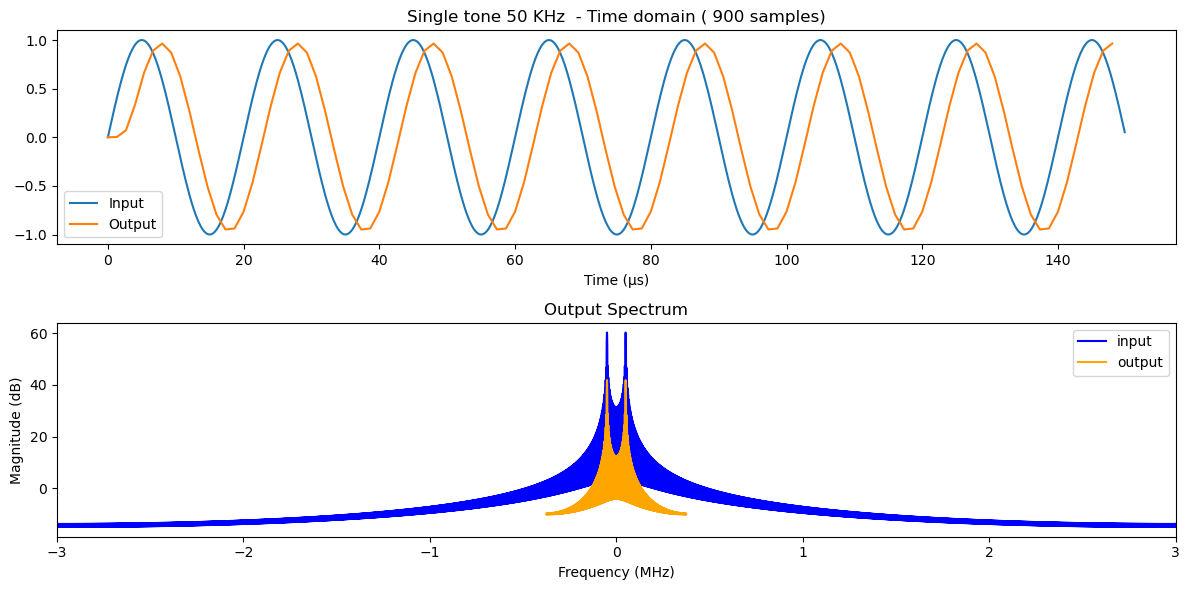

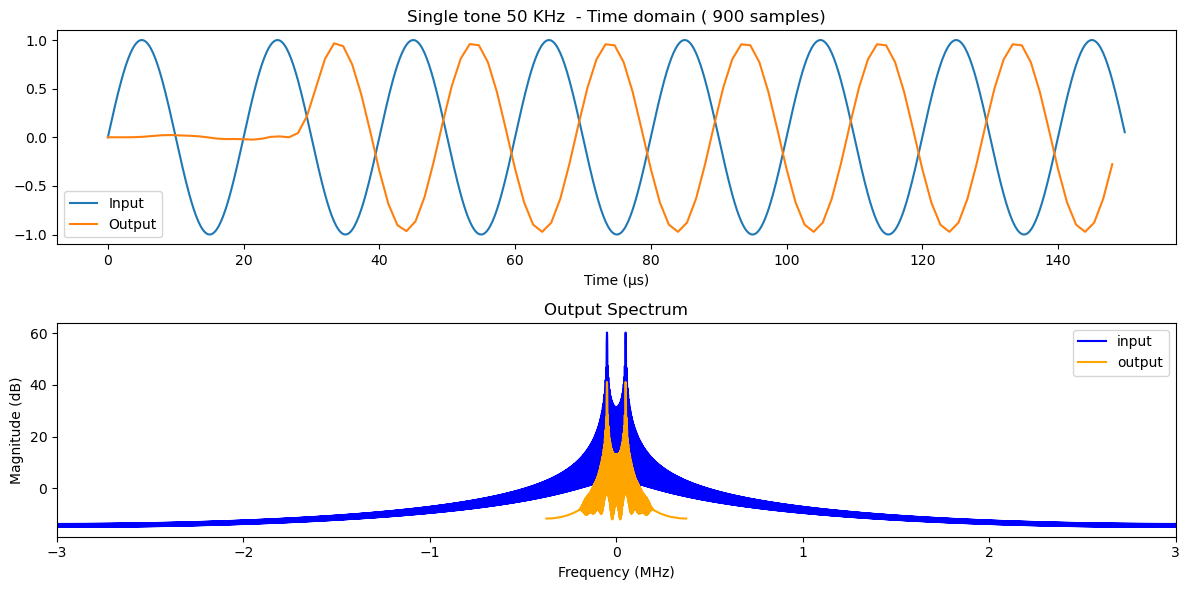

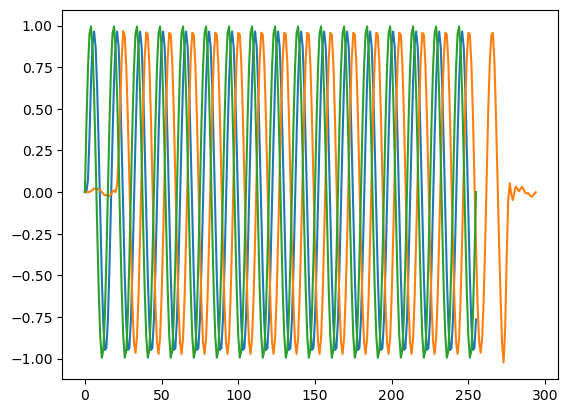

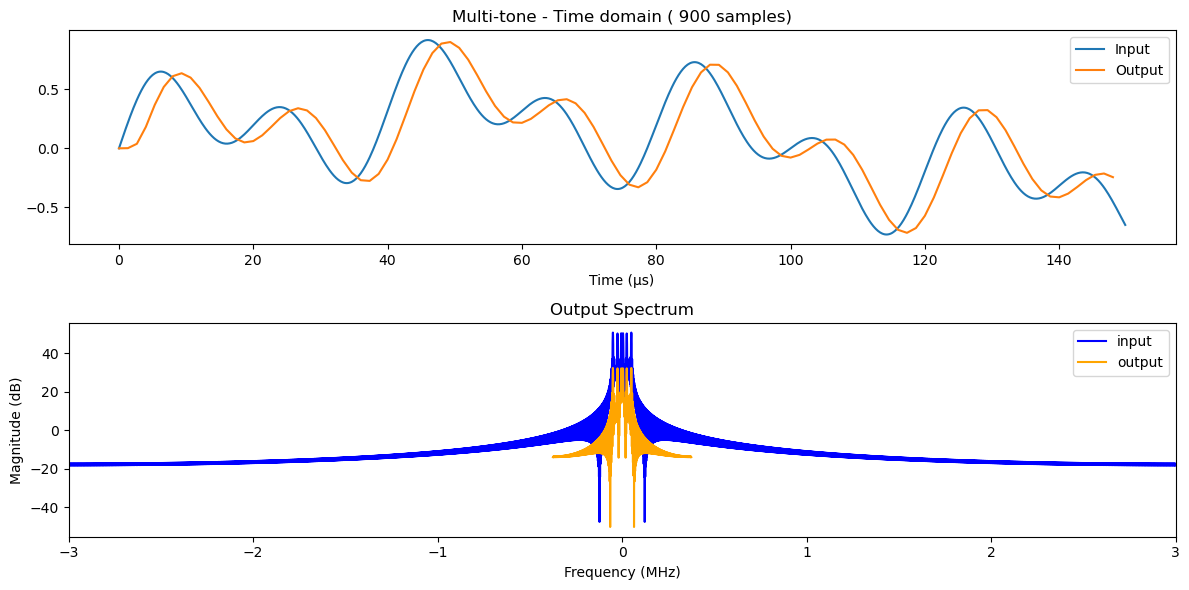

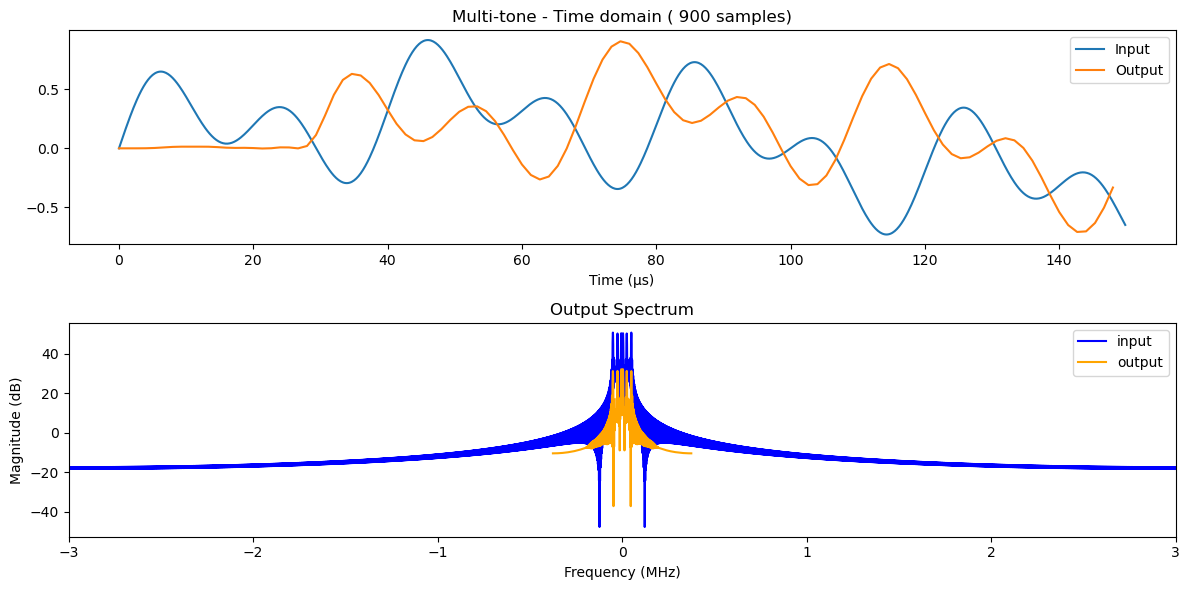

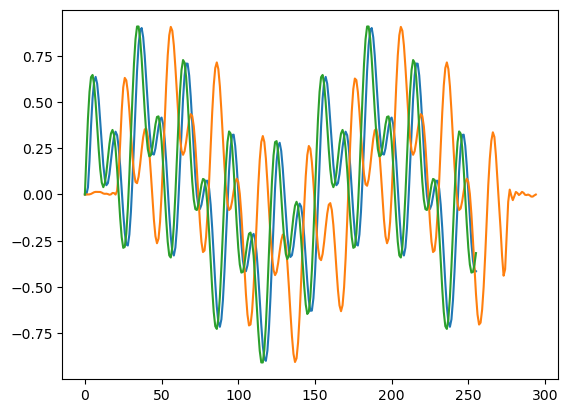

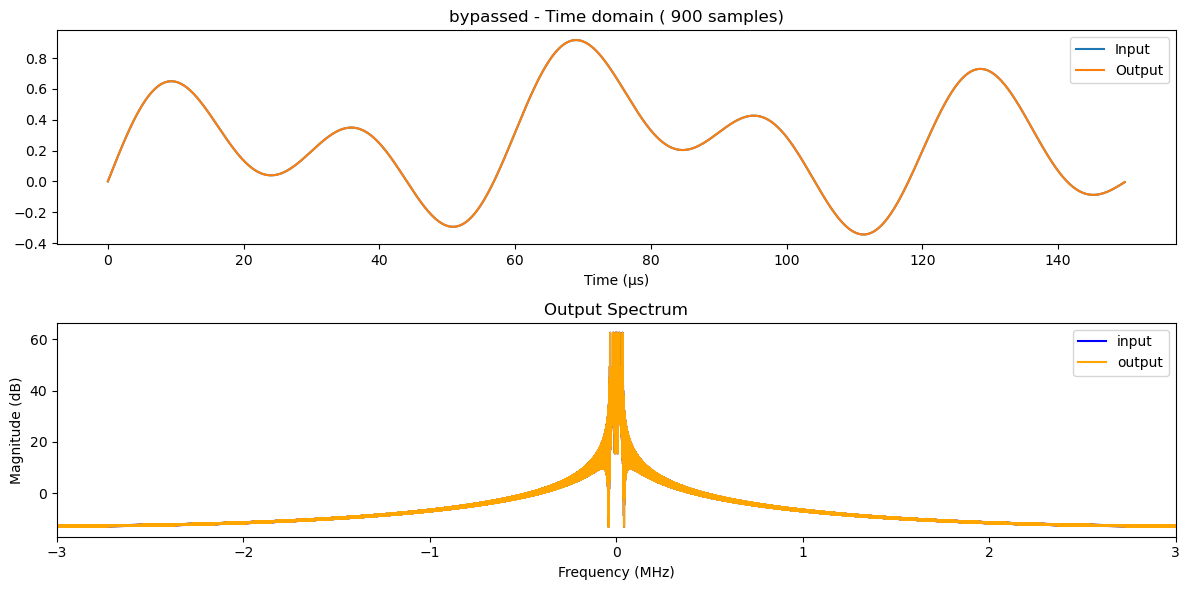

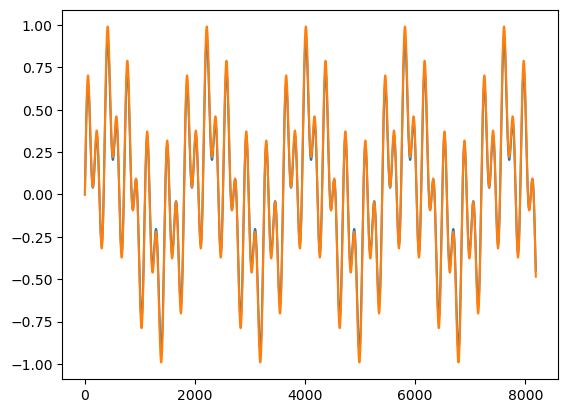

In [124]:
# ----------------- TESTING -----------------
fs_cic = 6e6
R = 8
# Different input signals
signals = {
    "Single tone 50 KHz ": np.sin(2*np.pi*5e4*t_2),
#     "Single tone .5 MHz": np.sin(2*np.pi*5e5*t),
#     "Two tones (1 MHz + 4 MHz)": np.sin(2*np.pi*1e6*t) + 0.7*np.sin(2*np.pi*2.4e6*t),
    #  "Wideband noise": np.random.randn(N),
    "Multi-tone": (np.sin(2*np.pi*0.5e4*t_2) + np.sin(2*np.pi*2.5e4*t_2) + np.sin(2*np.pi*5e4*t_2))/3
}

# Run tests
for name, sig in signals.items():
    y_1= cic_decimator(sig,R)
    y_2= cic_comp(sig,8)   
    plot_time_freq(sig, y_1, fs_cic, fs_cic /R, name,900 ,1  , R  , 900)
    plot_time_freq(sig, y_2, fs_cic, fs_cic /R, name,900 , 1 , R  , 900)
    plt.plot(y_1,label="no comp")
    plt.plot(y_2,label=" comp")
    plt.plot(sig[::R],label="original")
input_cic_1 = (np.sin(2*np.pi*0.5e4*t) + np.sin(2*np.pi*2.5e4*t) + np.sin(2*np.pi*5e4*t))/3
bypassed = cic_comp(input_cic_1,1)
plot_time_freq(input_cic_1, bypassed,fs_cic,fs_cic,"bypassed", 900,1,1,900)
plt.plot(bypassed)
plt.plot(input_cic_1* 1.08)

## DFE (integrated)

### I/O Testing

note: that when we use resampler be it interpolator or decimator the frequency DFT of the output is scaled be L/M of that resampling ratio so when we decimate by 4 it will be 1/4 of the input spectrum

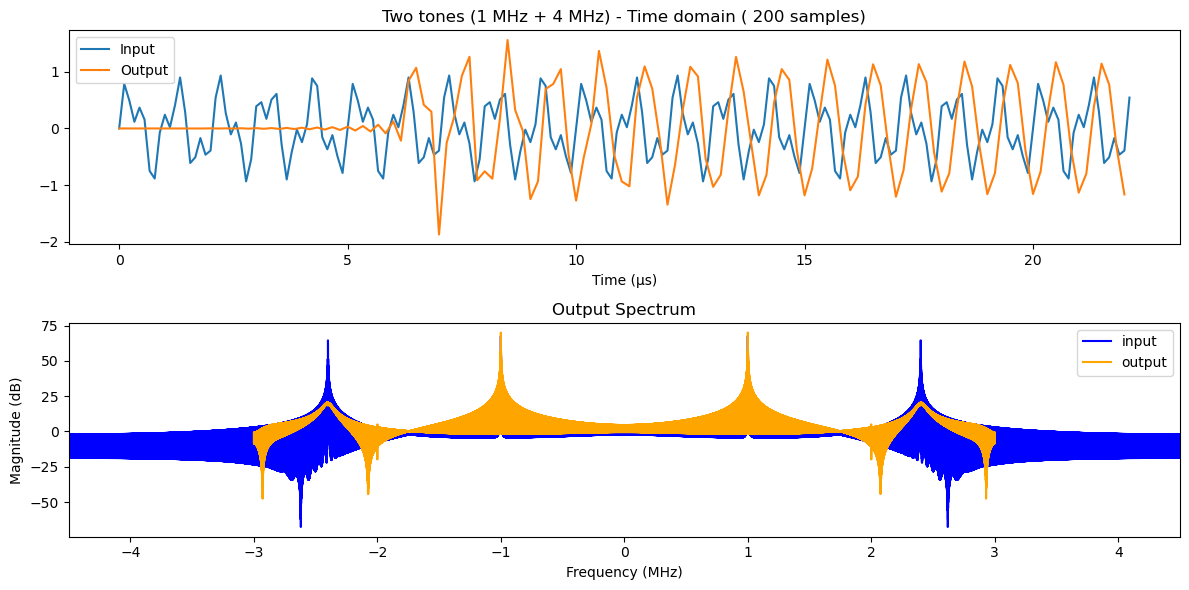

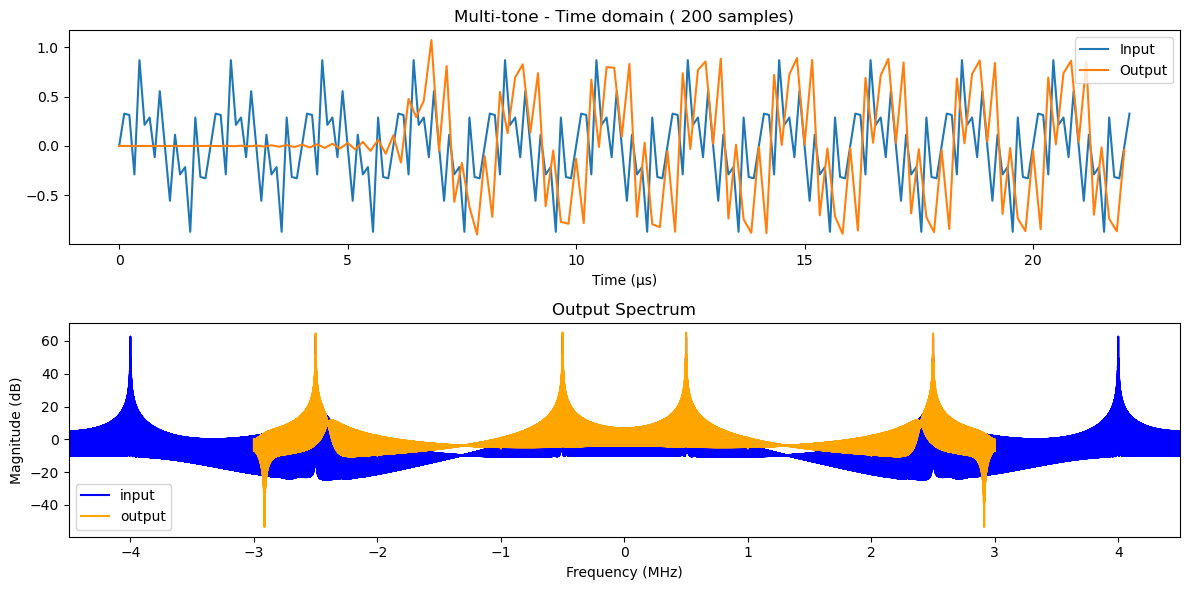

In [125]:
fs_in = 9e6
fs_out = 6e6
R = 1
# Different input signals
signals = {
    # "Single tone 50 KHz ": np.sin(2*np.pi*5e4*t),
#     "Single tone .5 MHz": np.sin(2*np.pi*5e5*t),
    "Two tones (1 MHz + 4 MHz)": (np.sin(2*np.pi*1e6*t) + 0.7*np.sin(2*np.pi*2.4e6*t))/1.7,
    #  "Wideband noise": np.random.randn(N),
    "Multi-tone": (np.sin(2*np.pi*0.5e6*t) + np.sin(2*np.pi*2.5e6*t) + np.sin(2*np.pi*5e6*t))/3
}

# Run tests
for name, sig in signals.items():
    y = dfe_integrated(sig ,R)
    plot_time_freq(sig, y*2, fs_in, fs_out /R, name,200 , 2 , M*R  , 200)

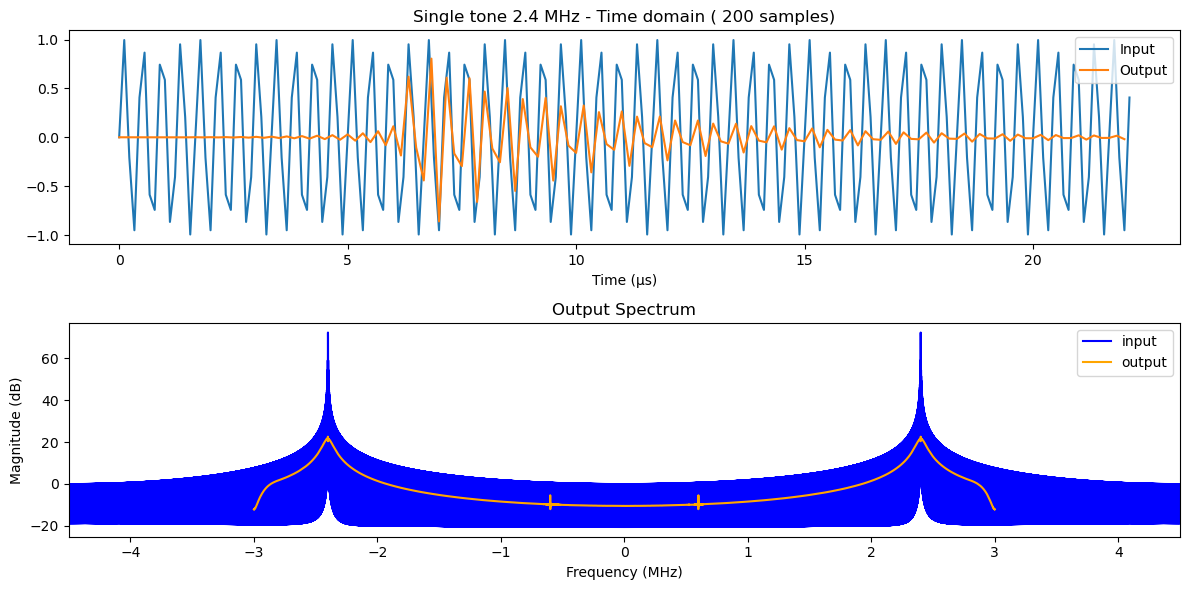

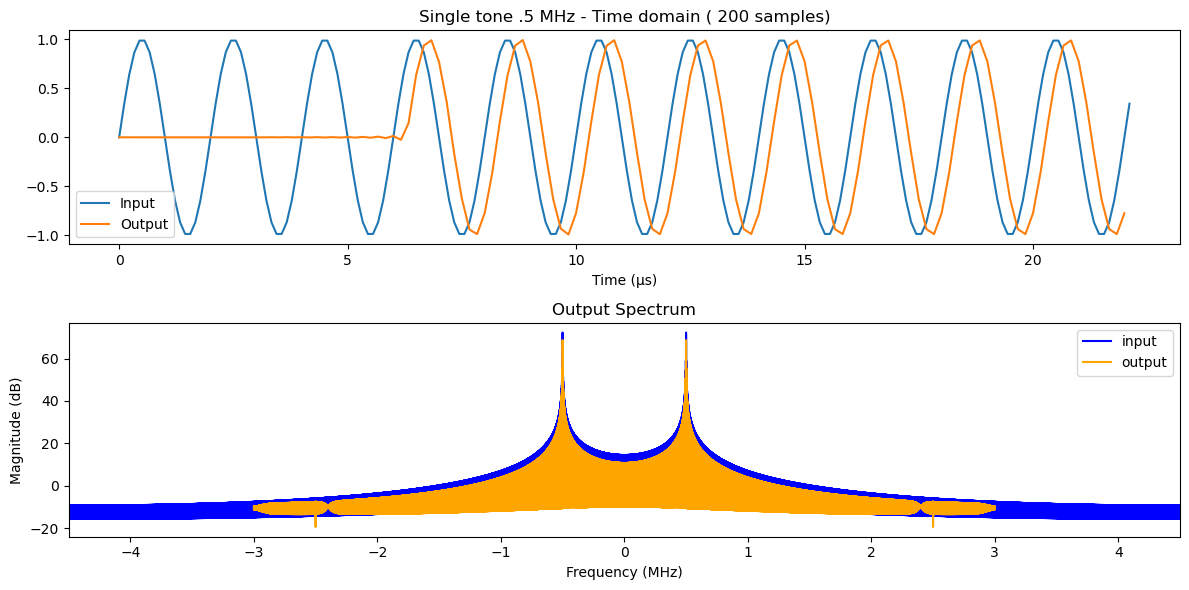

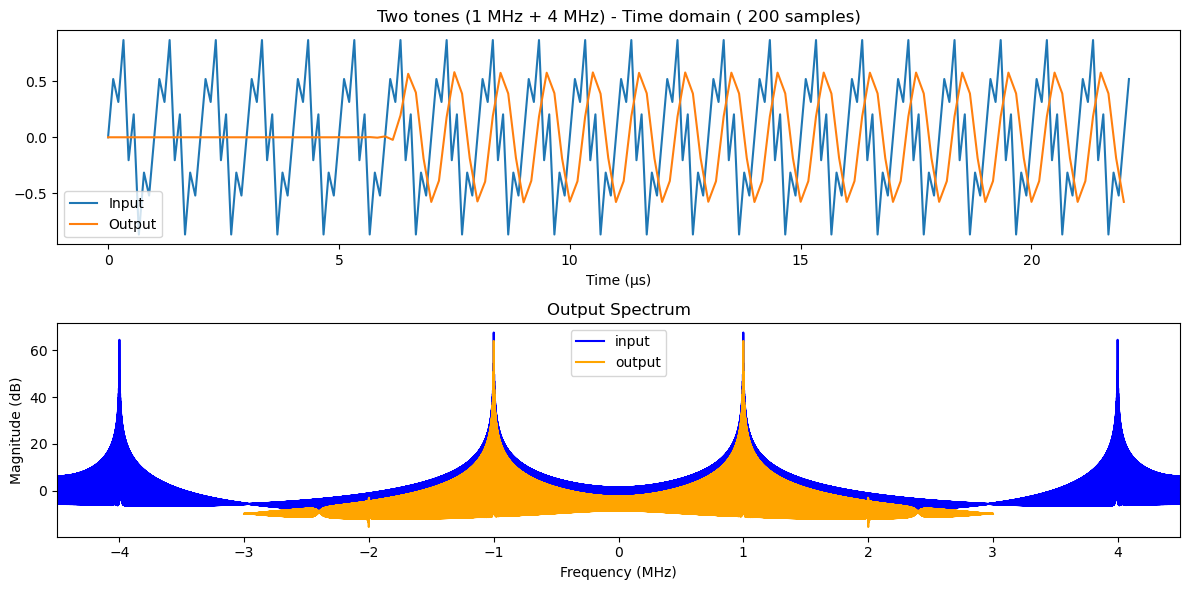

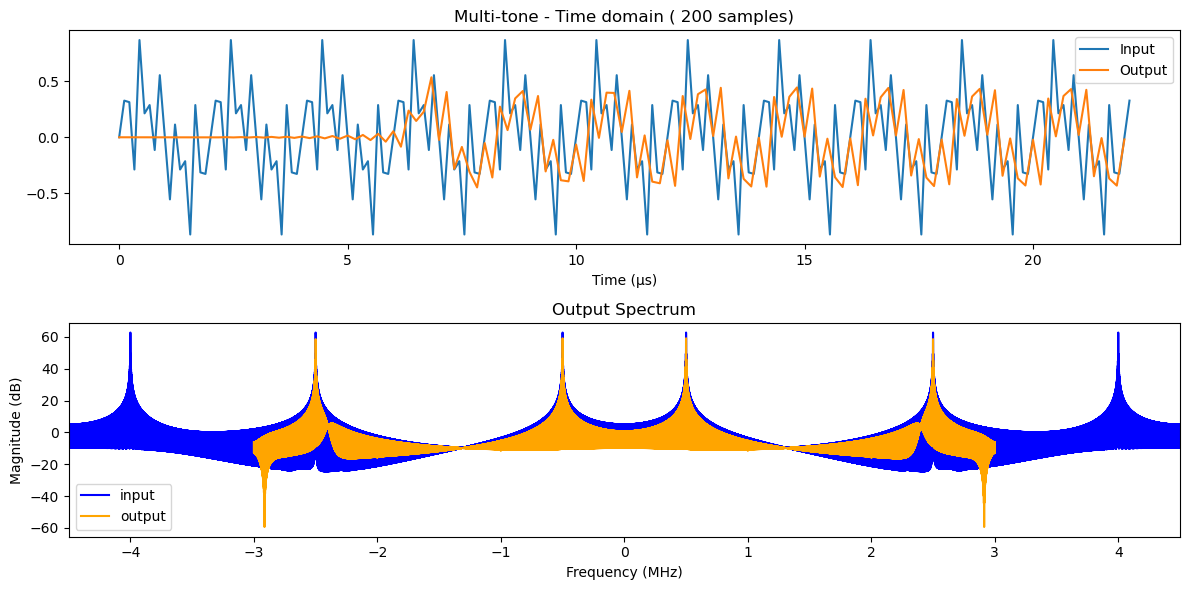

stop_2 low freq sig at R = 2


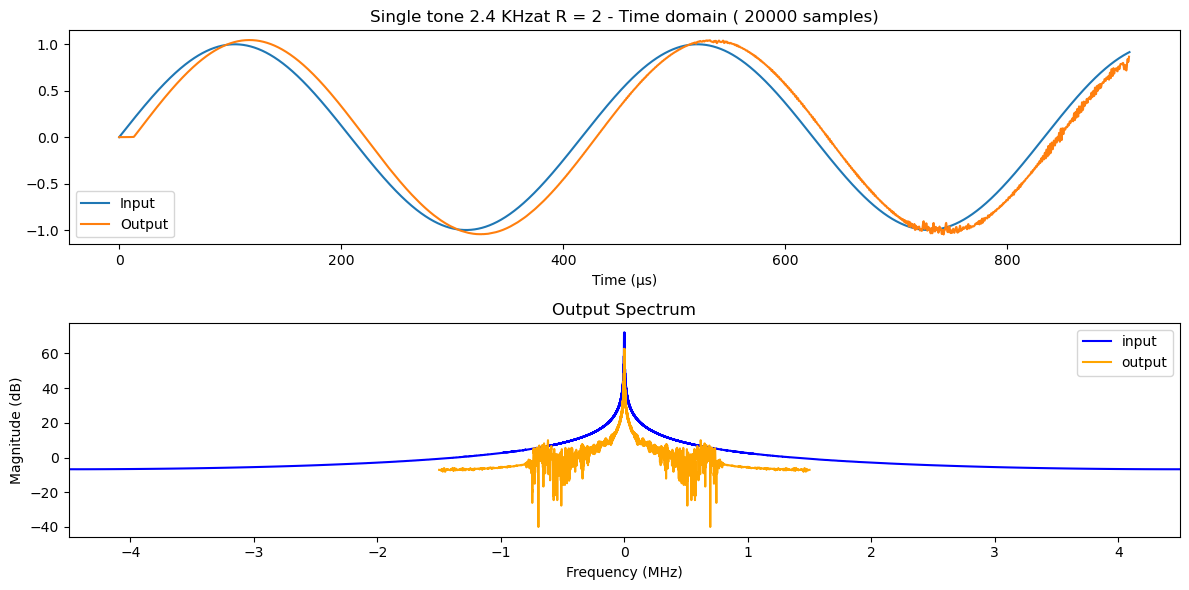

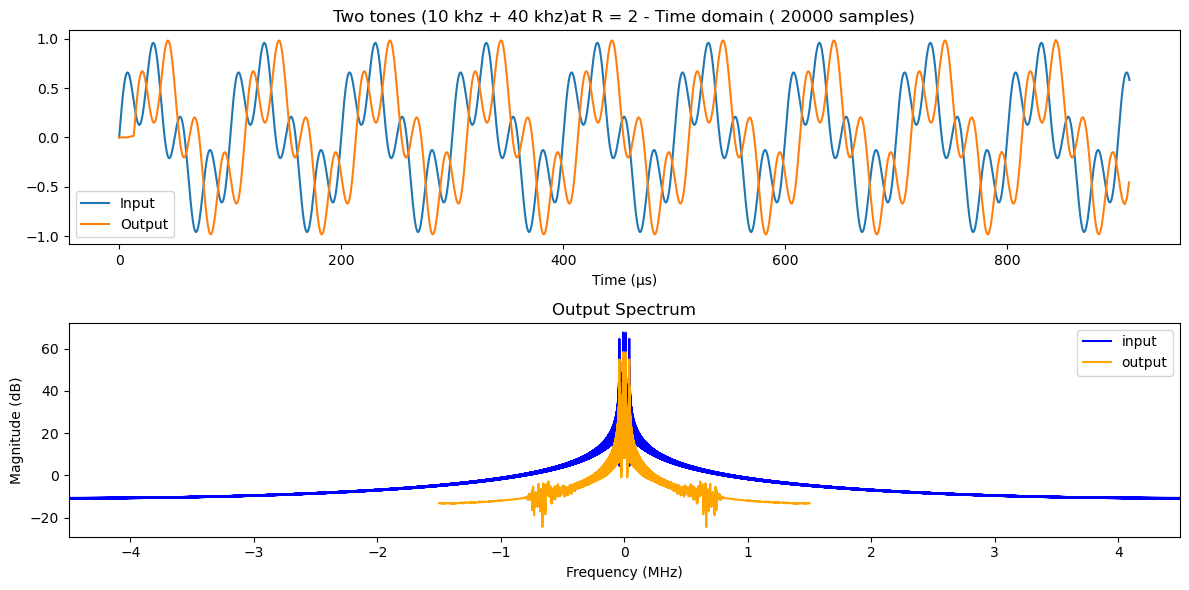

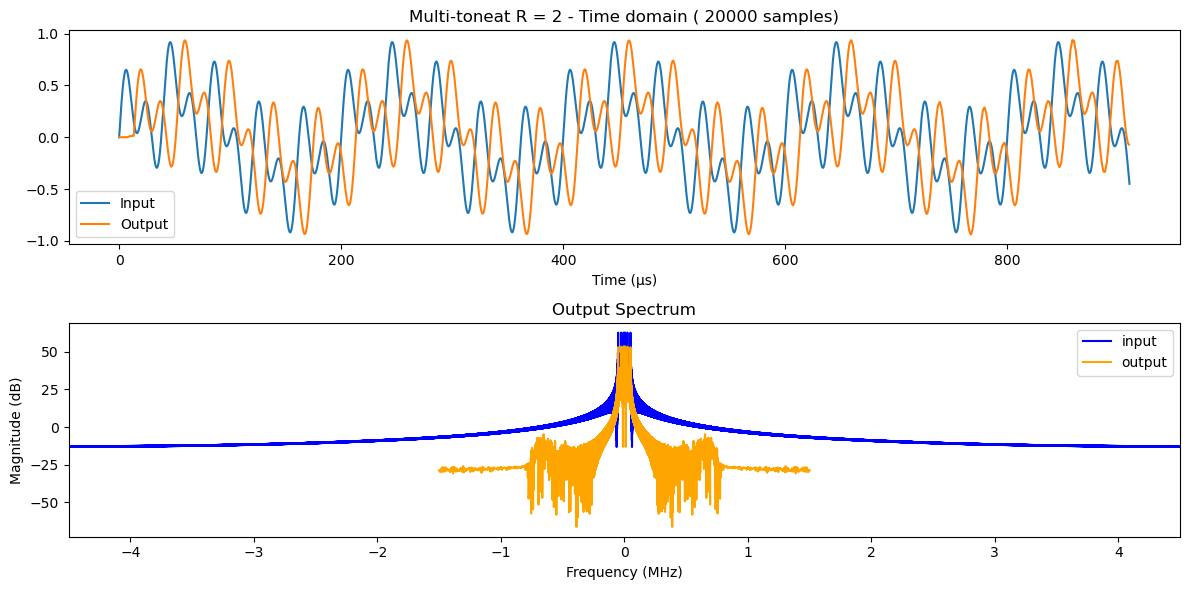

stop_3 low freq sig at R = 4


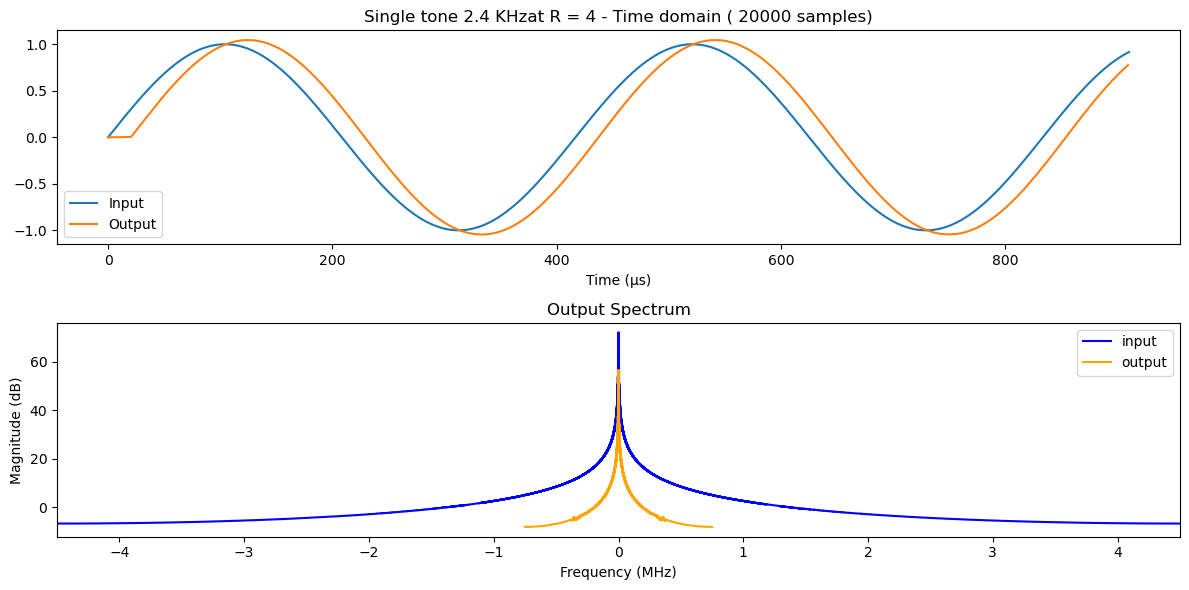

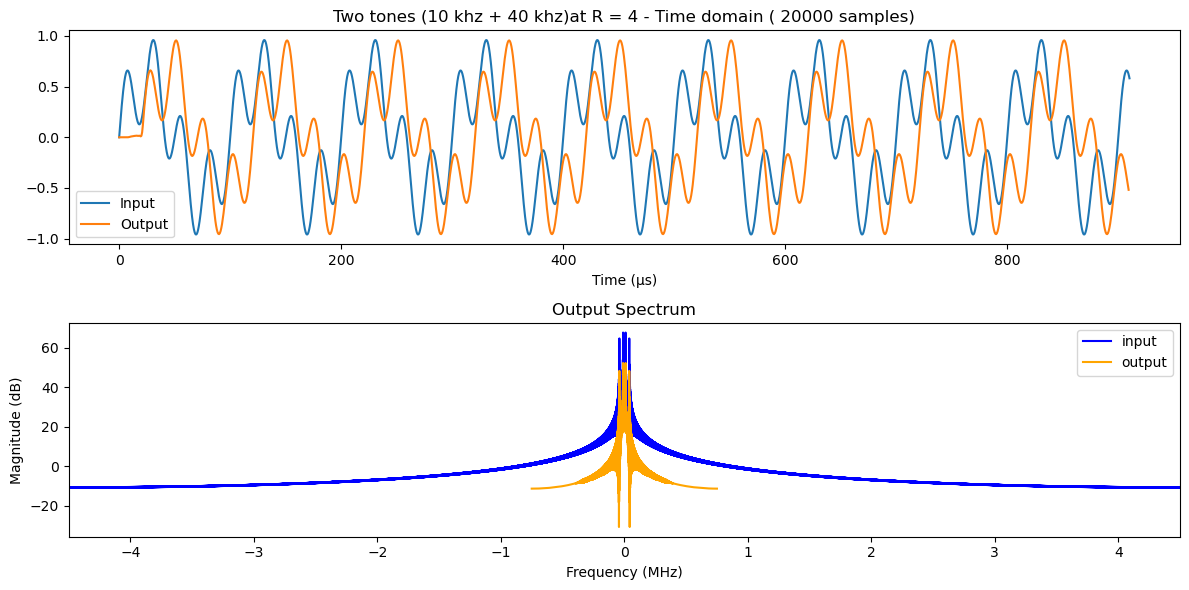

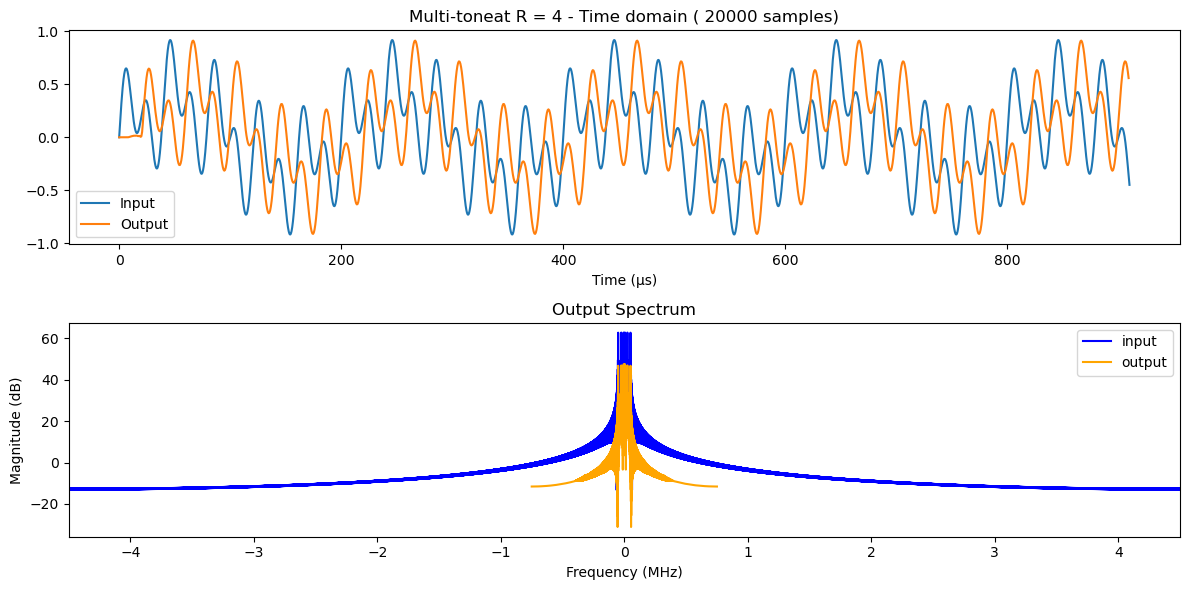

stop_4 low freq sig at R = 8


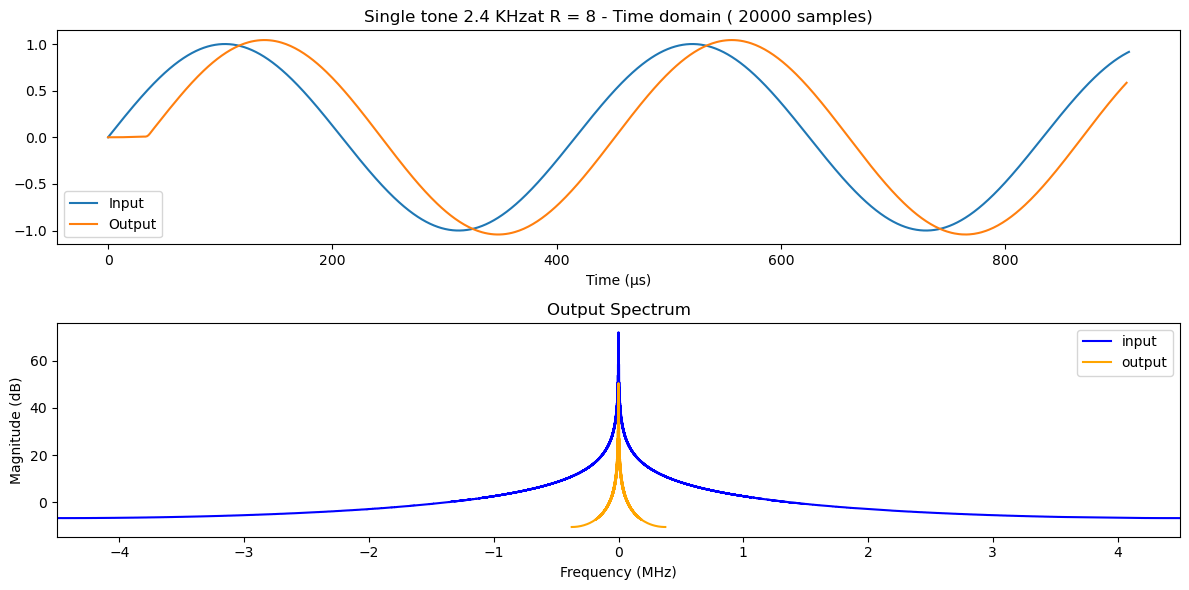

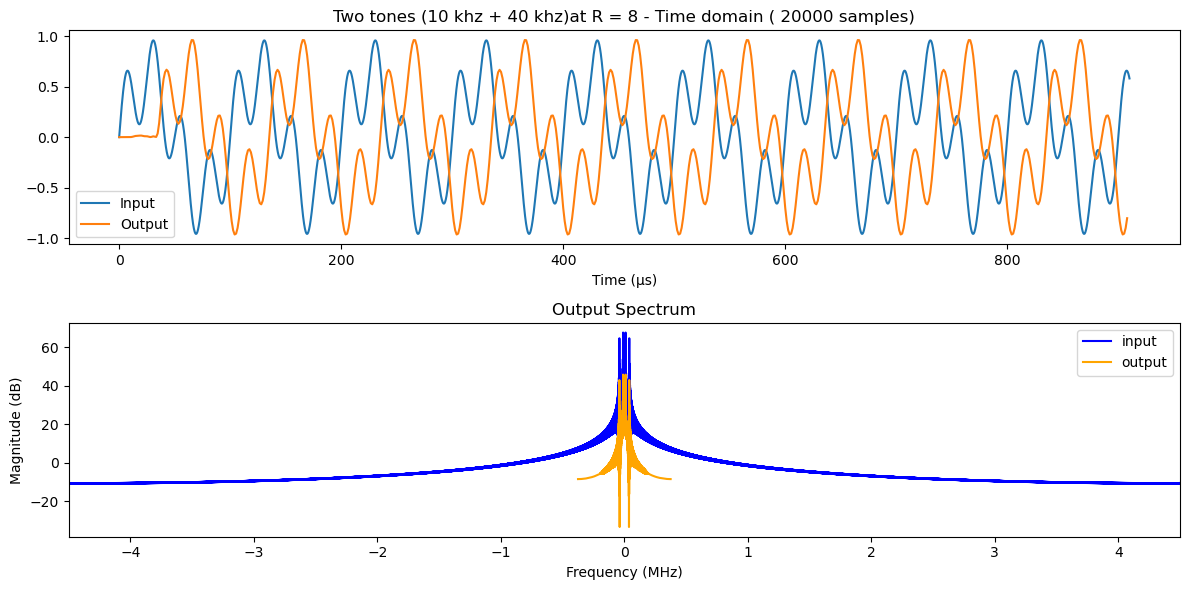

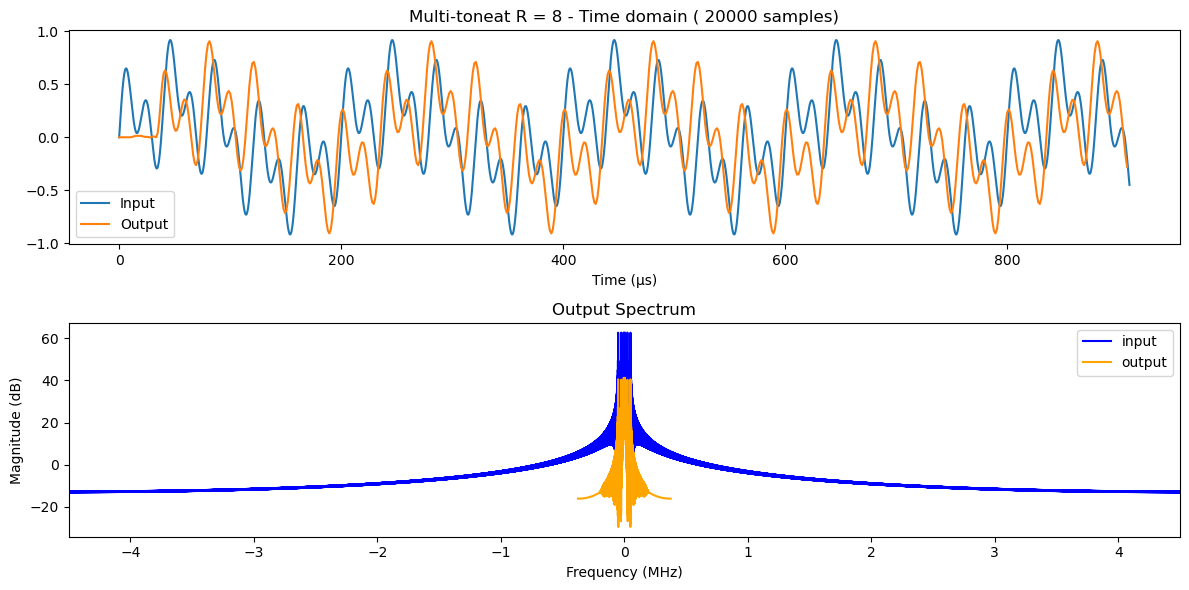

stop_5 low freq sig at R = 16


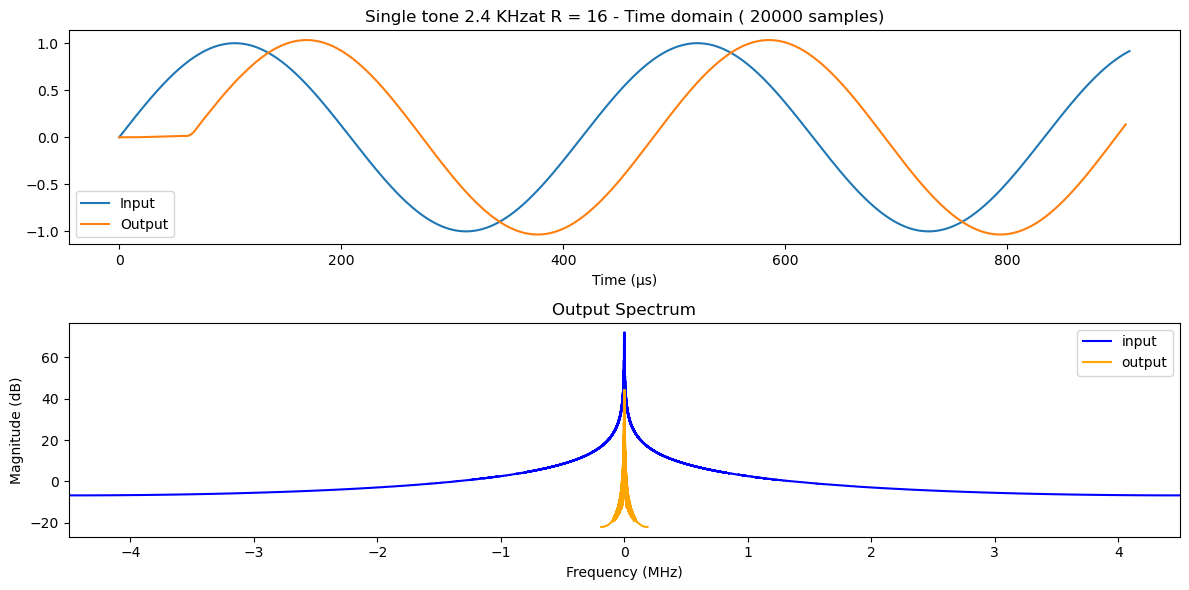

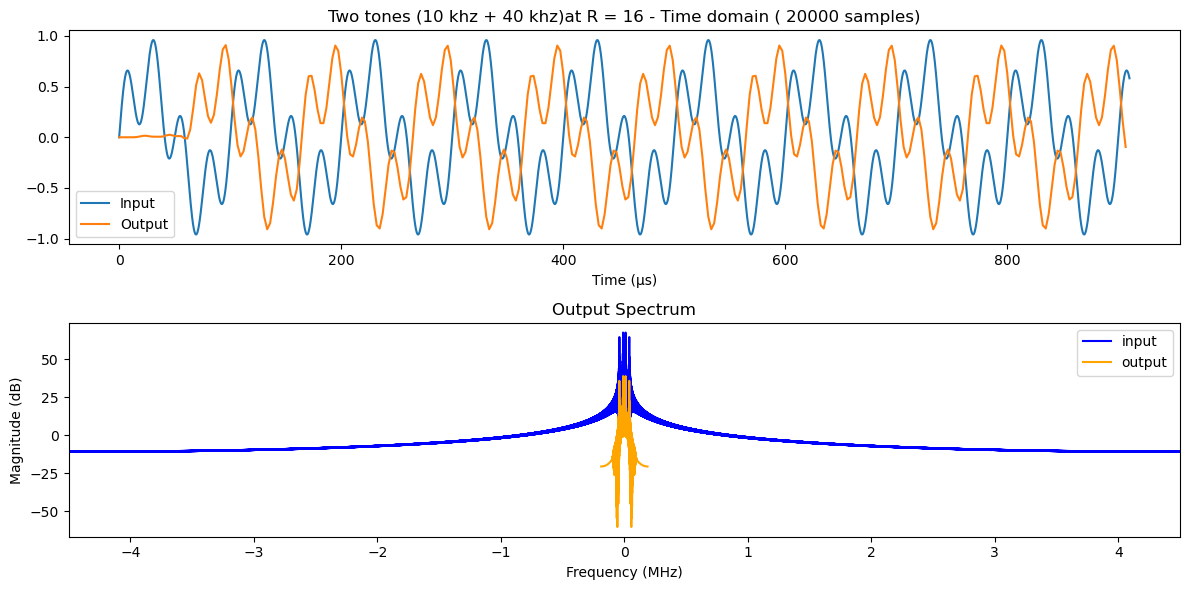

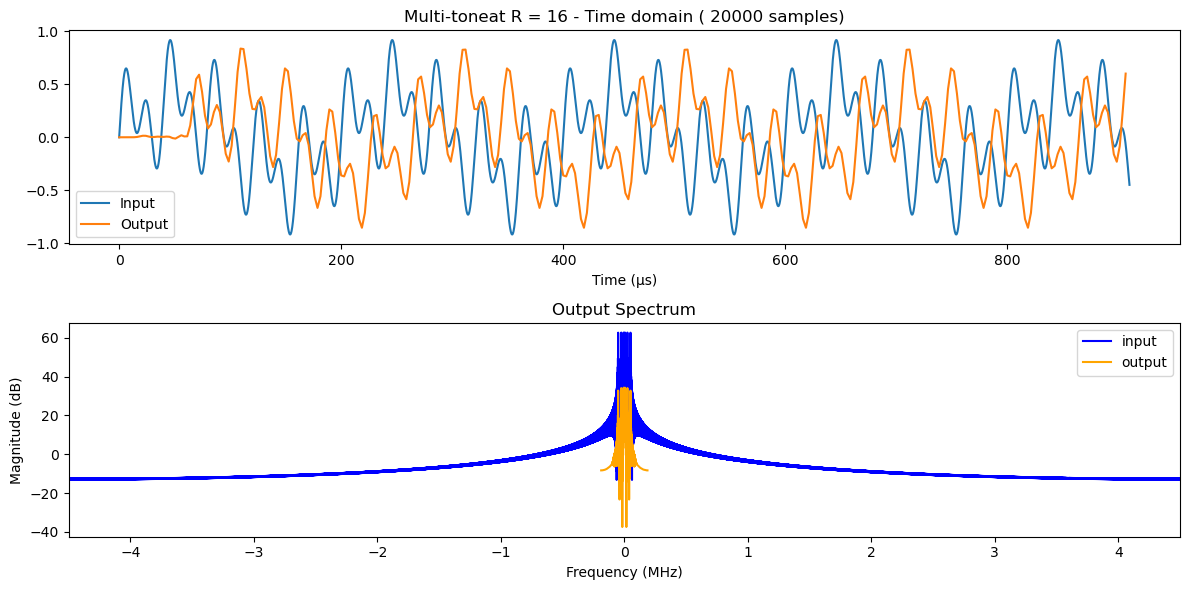

In [126]:
# ----------------- TESTING -----------------

# Different input signals
signals = {
    "Single tone 2.4 MHz": np.sin(2*np.pi*2.4e6*t),
    "Single tone .5 MHz": np.sin(2*np.pi*5e5*t),
    "Two tones (1 MHz + 4 MHz)": (np.sin(2*np.pi*1e6*t) + 0.7*np.sin(2*np.pi*4e6*t))/1.7,
    # "Wideband noise": np.random.randn(N),
    "Multi-tone": (np.sin(2*np.pi*0.5e6*t) + np.sin(2*np.pi*2.5e6*t) + np.sin(2*np.pi*5e6*t))/3
}

# Run tests
for name, sig in signals.items():
    y = dfe_integrated(sig, 1)
    plot_time_freq(sig, y, fs_in, fs_out, name,200,L,M)



signals_2 = {
    "Single tone 2.4 KHz": np.sin(2*np.pi*2.4e3*t),
    # "Single tone .5 MHz": np.sin(2*np.pi*2e4*t),
    "Two tones (10 khz + 40 khz)": (np.sin(2*np.pi*1e4*t) + 0.7*np.sin(2*np.pi*4e4*t))/1.7,
    # "Wideband noise": np.random.randn(N),
    "Multi-tone": (np.sin(2*np.pi*0.5e4*t) + np.sin(2*np.pi*2.5e4*t) + np.sin(2*np.pi*5e4*t))/3
}

print("stop_2 low freq sig at R = 2")

for name, sig in signals_2.items():
    y = dfe_integrated(sig, 2)
    plot_time_freq(sig, y, fs_in, fs_out/2, name+"at R = 2",20000,L,M*2,20000)

print("stop_3 low freq sig at R = 4")

for name, sig in signals_2.items():
    y = dfe_integrated(sig, 4)
    plot_time_freq(sig, y, fs_in, fs_out/4, name+"at R = 4",20000,L,M*4,20000)

print("stop_4 low freq sig at R = 8")

for name, sig in signals_2.items():
    y = dfe_integrated(sig, 8)
    plot_time_freq(sig, y, fs_in, fs_out/8, name+"at R = 8",20000,L,M*8,20000)

print("stop_5 low freq sig at R = 16")

for name, sig in signals_2.items():
    y = dfe_integrated(sig, 16)
    plot_time_freq(sig, y, fs_in, fs_out/16, name+"at R = 16",20000,L,M*16,20000)




### exhastive testbench


--- Decimation R = 1 ---
Expected: No decimation, all frequencies above 3 MHz and at 2.4 MHz attenuated by polyphase resampler pass


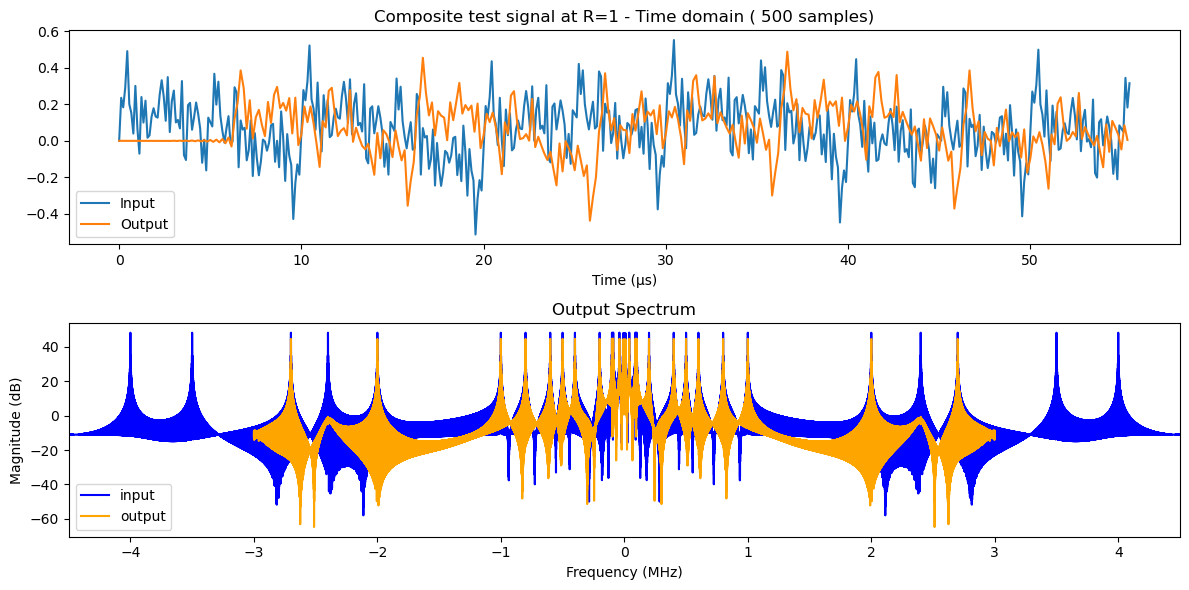


--- Decimation R = 2 ---
Expected: Frequencies above 1.5 MHz attenuated by CIC, others pass


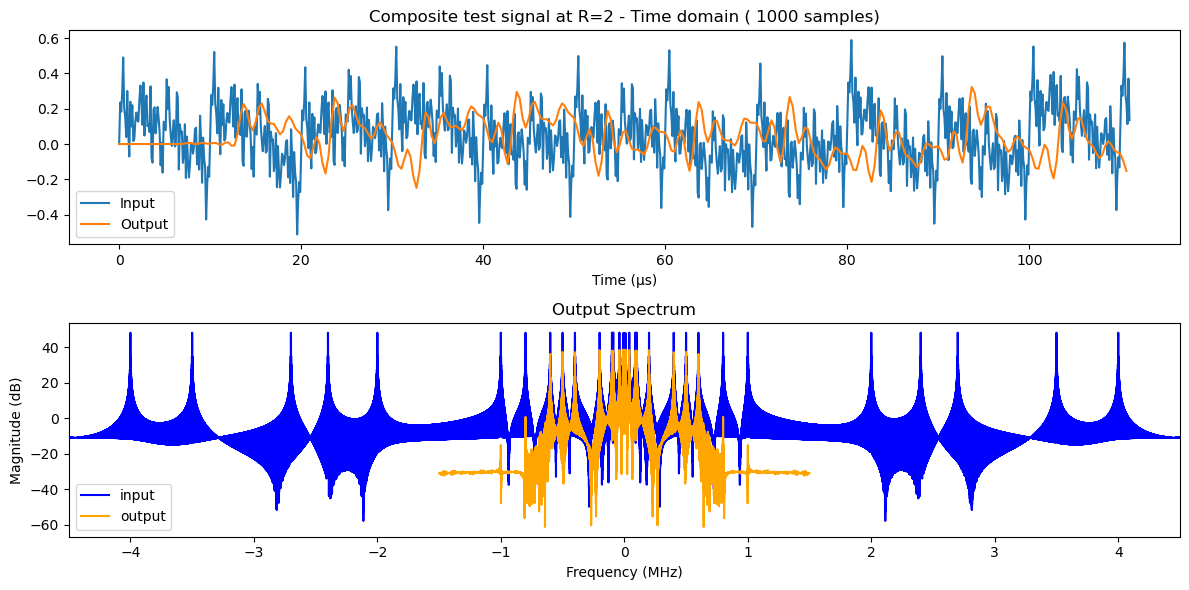


--- Decimation R = 4 ---
Expected: Frequencies above 0.75 MHz attenuated, aliasing may occur


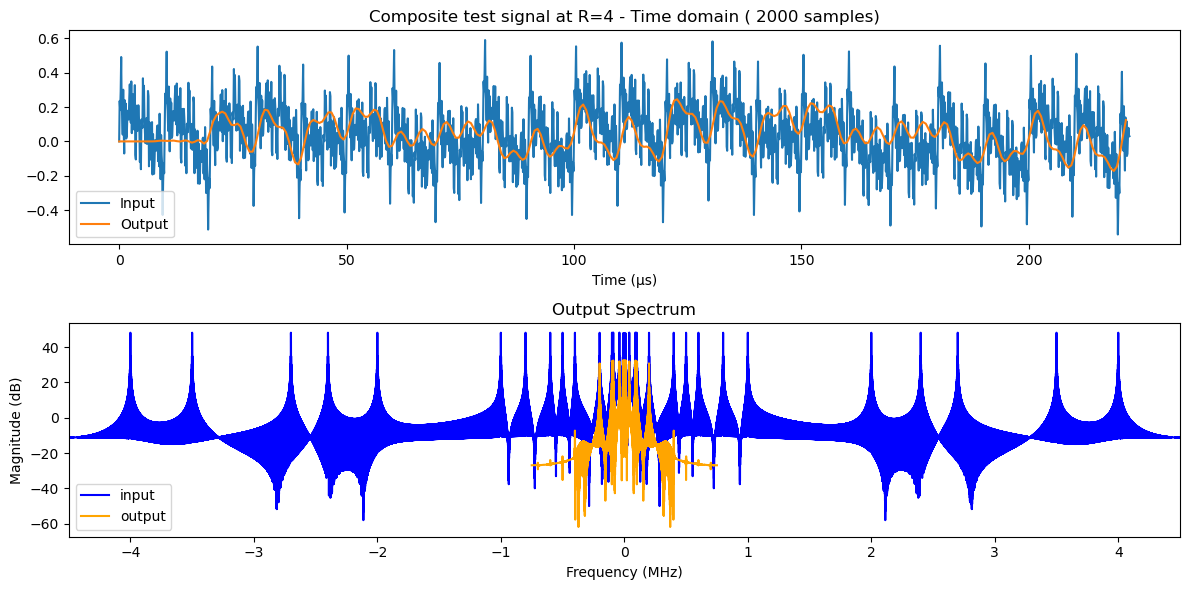


--- Decimation R = 8 ---
Expected: Frequencies above 0.375 MHz attenuated, strong aliasing for >0.75 MHz


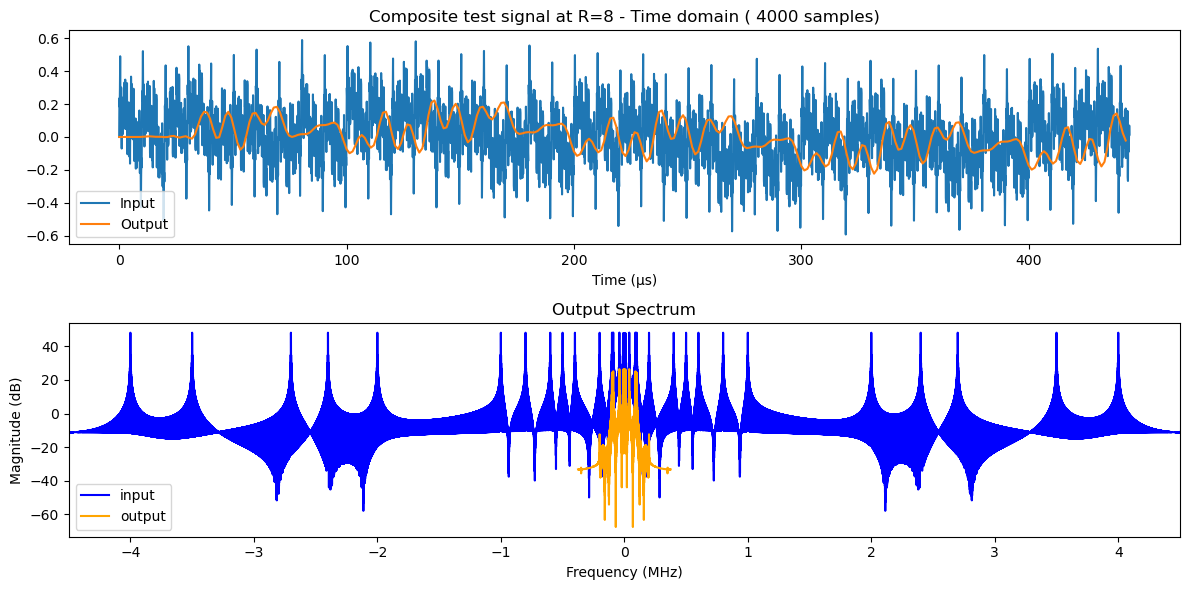


--- Decimation R = 16 ---
Expected: Frequencies above 0.1875 MHz strongly attenuated, only very low frequencies survive


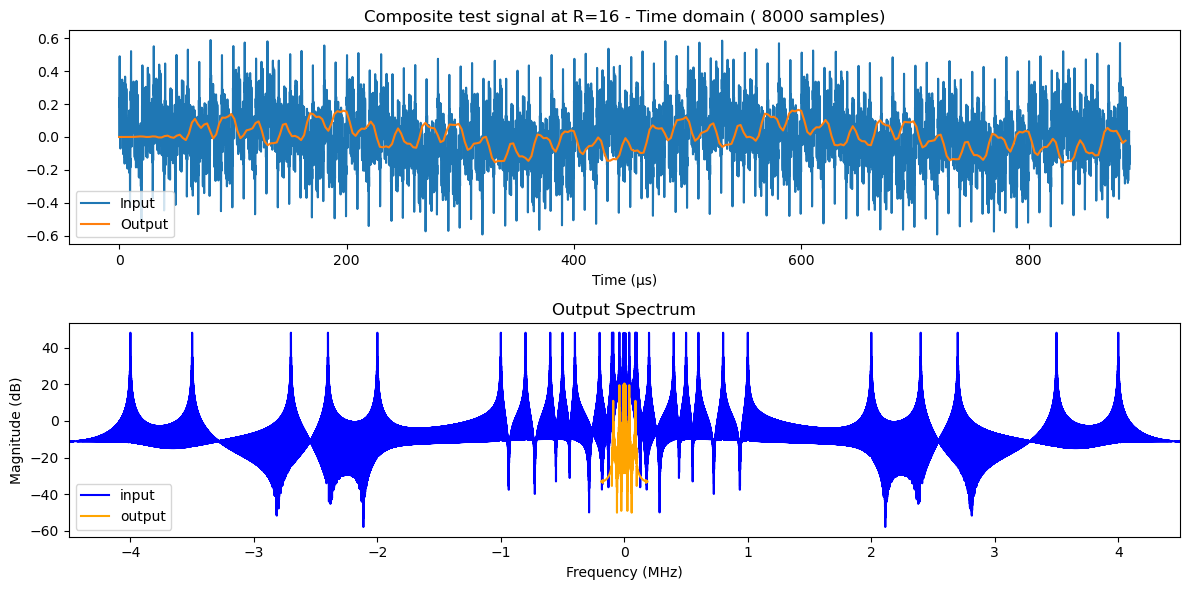

In [127]:
# ----------------- TESTING: Composite signal -----------------

# Frequencies to test (Hz)
# - Low freq: below final output
# - High freq: near CIC nulls / aliasing points
test_freqs = [
    2.4e3,    # low
    1e4, 4e4, 9e4 ,# low
    1e5, 2e5, 4e5, 5e5, 6e5, 8e5,   # mid
    1e6, 2.4e6, 2.7e6, 3.5e6, 5e6 , 7e6 # high / near CIC attenuation points
]

# Generate single composite signal
sig = sum(np.sin(2*np.pi*f*t) for f in test_freqs) / len(test_freqs)

# Decimation factors to test
R_list = [1, 2, 4, 8, 16]

# Expected behavior dictionary for annotation
expected_behavior = {
    1: "No decimation, all frequencies above 3 MHz and at 2.4 MHz attenuated by polyphase resampler pass",
    2: "Frequencies above 1.5 MHz attenuated by CIC, others pass",
    4: "Frequencies above 0.75 MHz attenuated, aliasing may occur",
    8: "Frequencies above 0.375 MHz attenuated, strong aliasing for >0.75 MHz",
    16:"Frequencies above 0.1875 MHz strongly attenuated, only very low frequencies survive"
}

# Loop over R
for R in R_list:
    print(f"\n--- Decimation R = {R} ---")
    print("Expected:", expected_behavior[R])
    
    y = dfe_integrated(sig, R)
    fs_out_R = 6e6 / R
    plot_time_freq(sig, y, 9e6, fs_out_R, f"Composite test signal at R={R}", 500*R, 2, 3*R, 500*R)